# Load modules and dataset

In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install scikeras

In [ ]:
#from google.colab import drive
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, Bidirectional
from sklearn.model_selection import StratifiedKFold, cross_validate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras import backend as K
from tensorflow.keras.utils import plot_model

In [ ]:
#αυτό το κελί δεν εκτελείται στο Jupyter
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/NEWS_DATASET/final.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
def strip(row):
  return row['text'].strip('"')

df['text'] = df.apply(strip,axis=1)
df.head()

,title,text,label
0,China says Trump plan to move embassy in Israe...,BEIJING (Reuters) - China expressed concern on...,true
1,India says ready for stronger U.S. ties after ...,NEW DELHI (Reuters) - India stood ready to fur...,true
2,A PRESIDENT WHO’S UNSERIOUS AND UNDIGNIFIED…DO...,America deserves so much better and should get...,fake
3,#DNC GIVES ANTI-HILLARY Dems Free Speech Cage ...,"It s just cleaner that way You know, keeping a...",fake
4,Castro meets North Korea minister amid hope Cu...,HAVANA (Reuters) - Cuban President Raul Castro...,true


In [ ]:
label_encoder = LabelEncoder()
label = df['label']
labels_encoded = label_encoder.fit_transform(label)
df['label'] = labels_encoded
df.head()

,title,text,label
0,China says Trump plan to move embassy in Israe...,BEIJING (Reuters) - China expressed concern on...,1
1,India says ready for stronger U.S. ties after ...,NEW DELHI (Reuters) - India stood ready to fur...,1
2,A PRESIDENT WHO’S UNSERIOUS AND UNDIGNIFIED…DO...,America deserves so much better and should get...,0
3,#DNC GIVES ANTI-HILLARY Dems Free Speech Cage ...,"It s just cleaner that way You know, keeping a...",0
4,Castro meets North Korea minister amid hope Cu...,HAVANA (Reuters) - Cuban President Raul Castro...,1


# Fine Tune DistilBERT

In [ ]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True


In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(df['text'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, df['label'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['text'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['text'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 2
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/2
17959/17959 [==============================] - 2529s 139ms/step - loss: 0.0082 - accuracy: 0.9981
Epoch 2/2
17959/17959 [==============================] - 2413s 134ms/step - loss: 0.0142 - accuracy: 0.9965


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

In [ ]:
print(benchmarks)

{'loss': 0.0009140346082858741, 'accuracy': 0.9997772574424744}


In [ ]:
model_distil.summary()

In [ ]:
model_distil.save_pretrained('/content/drive/MyDrive/NEWS_DATASET/distil_article')

# Create Embeddings

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

#### ISOT Title Embeddings DistilBERT

In [ ]:
from tqdm import tqdm

batch_size = 1
titles = df['title'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 44898/44898 [1:24:26<00:00,  8.86it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
labels = df['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy', labels)

#### ISOT Text Embeddings DistilBERT

In [ ]:
model_distil = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/NEWS_DATASET/distil_article',num_labels=2,output_hidden_states=True)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/NEWS_DATASET/distil_article.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
copy = df.copy()

In [ ]:
from tqdm import tqdm
batch_size = 1
text = copy['text'].tolist()
embeddings = []

for i in tqdm(range(0, len(text), batch_size)):
    batch_titles = text[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

 16%|█▋        | 7361/44898 [13:45<1:03:04,  9.92it/s]

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
label_encoder = LabelEncoder()
copy['label'] = label_encoder.fit_transform(copy['label'])
labels = copy['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/NEWS_DATASET/embeddings_text_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/NEWS_DATASET/labels_text_distilbert.npy', labels)

#### ISOT Text Max Worth Embeddings DistilBERT

In [ ]:
#δεν χρειάζεται να εκτελεστεί το συγκεκριμένο κελί
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# δεν χρειάζεται να εκτελεστεί το συγκεκριμένο τμήμα γιατί διαρκεί περίπου 4¨30 ώρες και έχουμε ήδη το τελικό dataframe
import requests
import json
from tqdm import tqdm
def get_sentence_scores(sentences, api_key):
  api_endpoint = "https://idir.uta.edu/claimbuster/api/v2/score/text/sentences/"
  request_headers = {"x-api-key": api_key}
  payload = {"input_text": sentences}
  api_response = requests.post(url=api_endpoint, json=payload, headers=request_headers)
  return api_response.json()


In [ ]:
#δεν χρειάζεται να εκτελεστεί
def max_worth(text,limit):
  api_key = '*****************************'
  c = get_sentence_scores(text,api_key)
  c = sorted(c['results'], key=lambda x: float(x['score']), reverse=True)
  for res in c:
    res['word_count'] = len(res['text'].split())

  total_words = 0
  last_index = -1

  for i, item in enumerate(c):
    text = item['text']
    word_count = len(text.split())
    if total_words + word_count > 450:
      break
    total_words += word_count
    last_index = i

  c = c[:last_index+1]
  c = sorted(c, key=lambda x: x['index'])
  c = ' '.join([result['text'] for result in c])

  return c

In [ ]:
#δεν χρειάζεται να εκτελεστεί
df['max'] = tqdm(df['text'].apply(max_worth,limit=450))

In [ ]:
#δεν χρειάζεται να εκτελεστεί το συγκεκριμένο κελί
df.to_csv('/content/drive/My Drive/NEWS_DATASET/final_max.csv', index=False)

In [ ]:
#δεν χρειάζεται να εκτελεστεί το συγκεκριμένο κελί
df.head()

In [ ]:
#αυτό το κελί χρειάζεται να εκτελεστεί μόνο σε περίπτωση που αποτύχει το fine tuning παραπάνω
model_distil = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/NEWS_DATASET/distil_article',num_labels=2,output_hidden_states=True)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/NEWS_DATASET/distil_article.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
path = '/content/drive/My Drive/NEWS_DATASET/final_max.csv'
copy = pd.read_csv(path,delimiter=',')

450


Text(0.5, 1.0, 'Text Length distribution (Max_Worth)')

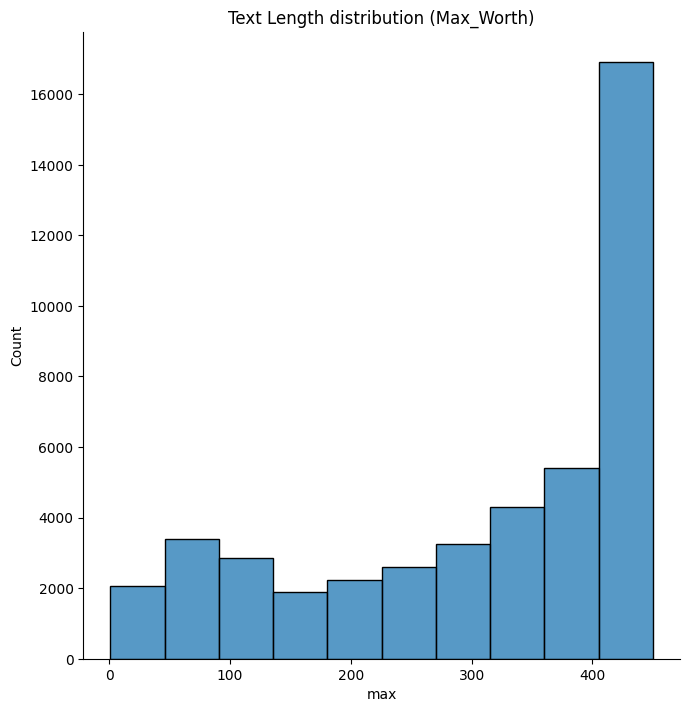

In [ ]:
word_counts = copy['max'].apply(lambda x: len(str(x).split()))
print(word_counts.max())
sns.displot(word_counts, kde=False, bins=10, height=7, aspect=1)
plt.title('Text Length distribution (Max_Worth)')

In [ ]:
from tqdm import tqdm
batch_size = 1
text = copy['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(text), batch_size)):
    batch_titles = str(text[i:i+batch_size])

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 44898/44898 [1:24:11<00:00,  8.89it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
label_encoder = LabelEncoder()
copy['label'] = label_encoder.fit_transform(copy['label'])
labels = copy['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/NEWS_DATASET/embeddings_textmax_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/NEWS_DATASET/labels_textmax_distilbert.npy', labels)

# Statements -  Titles

## **CNN-DistilBERT**

In [ ]:
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

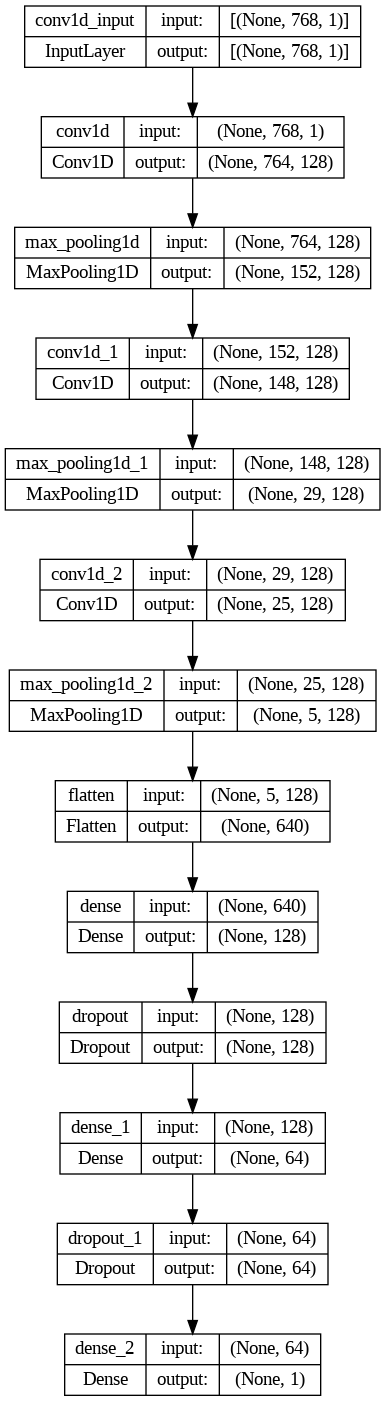

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels,epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 25s 6ms/step - loss: 0.0321 - accuracy: 0.9915
Epoch 2/10
2245/2245 [==============================] - 19s 9ms/step - loss: 0.0225 - accuracy: 0.9943
Epoch 3/10
2245/2245 [==============================] - 21s 9ms/step - loss: 0.0198 - accuracy: 0.9944
Epoch 4/10
2245/2245 [==============================] - 15s 7ms/step - loss: 0.0198 - accuracy: 0.9939
Epoch 5/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0180 - accuracy: 0.9945
Epoch 6/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0185 - accuracy: 0.9943
Epoch 7/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0184 - accuracy: 0.9944
Epoch 8/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0187 - accuracy: 0.9945
Epoch 9/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0187 - accuracy: 0.9946
Epoch 10/10
2245/2245 [==============================] - 14s 6ms/step - l

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 3ms/step
Test Accuracy: 0.9940980076789856
Test F1 Score: 0.9939490809453135
Test Recall: 0.9970224461749886
Precision: 0.9908946050534942


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

281/281 [==============================] - 1s 3ms/step
[[4574   40]
 [  13 4353]]


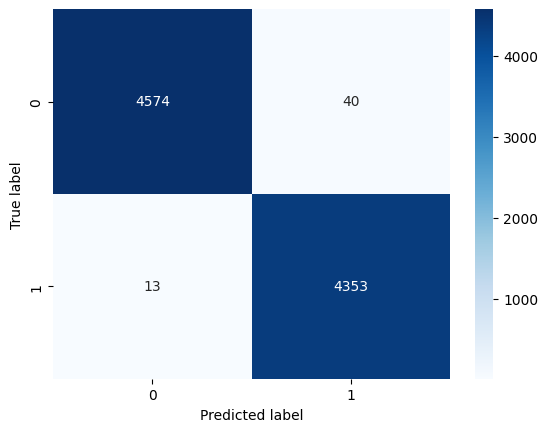

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    print(classification_report(test_labels, y_pred))

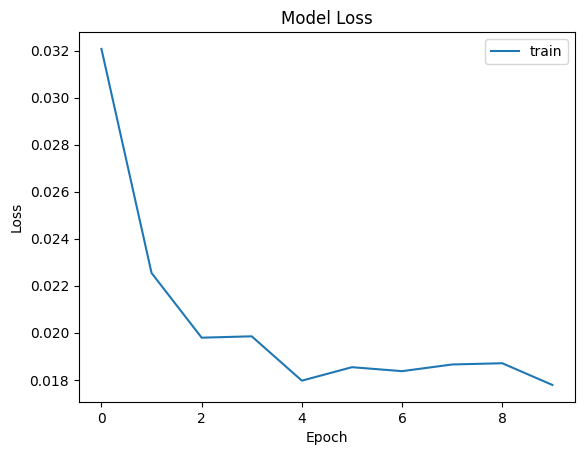

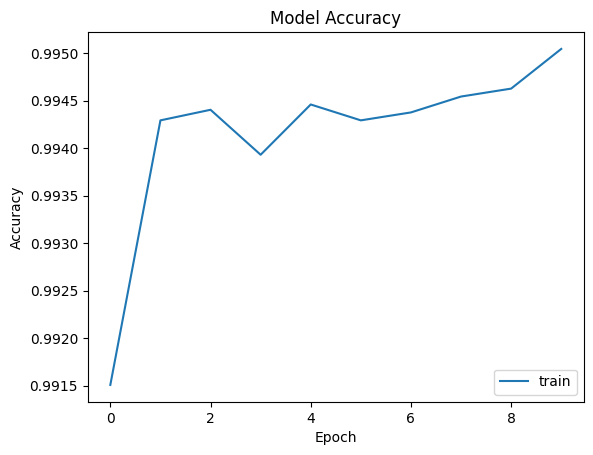

281/281 [==============================] - 1s 3ms/step


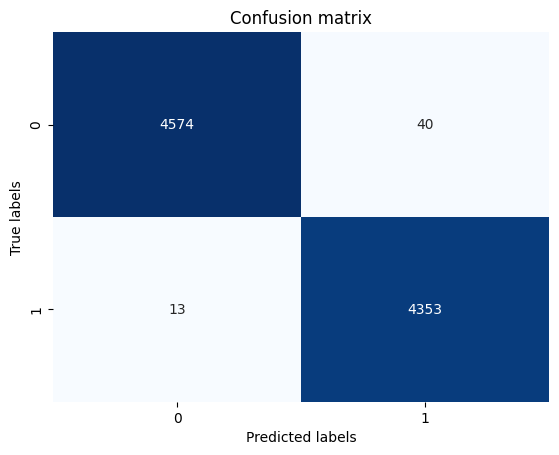

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4614
           1       0.99      1.00      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 13s 6ms/step - loss: 0.0334 - accuracy: 0.9902
Epoch 2/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0196 - accuracy: 0.9943
Epoch 3/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0191 - accuracy: 0.9949
Epoch 4/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0198 - accuracy: 0.9943
Epoch 5/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0176 - accuracy: 0.9951
Epoch 6/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0190 - accuracy: 0.9946
Epoch 7/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0189 - accuracy: 0.9944
Epoch 8/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0179 - accuracy: 0.9948
Epoch 9/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0184 - accuracy: 0.9945
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.00)
Cross-Validation Loss: 0.02 (+/- 0.01)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

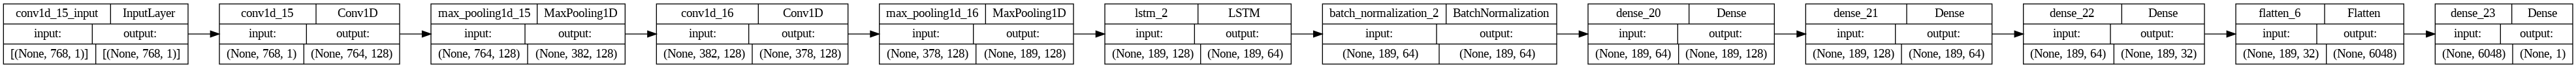

In [ ]:
plot_model(model2, to_file='model.png', show_shapes=True, rankdir='LR')

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 35s 13ms/step - loss: 0.0215 - accuracy: 0.9939
Epoch 2/10
2245/2245 [==============================] - 31s 14ms/step - loss: 0.0183 - accuracy: 0.9945
Epoch 3/10
2245/2245 [==============================] - 31s 14ms/step - loss: 0.0170 - accuracy: 0.9943
Epoch 4/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0163 - accuracy: 0.9944
Epoch 5/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0165 - accuracy: 0.9950
Epoch 6/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0161 - accuracy: 0.9951
Epoch 7/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0156 - accuracy: 0.9951
Epoch 8/10
2245/2245 [==============================] - 29s 13ms/step - loss: 0.0157 - accuracy: 0.9952
Epoch 9/10
2245/2245 [==============================] - 29s 13ms/step - loss: 0.0150 - accuracy: 0.9955
Epoch 10/10
2245/2245 [==============================] - 29s 13m

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 3s - loss: 0.0185 - accuracy: 0.9943 - 3s/epoch - 11ms/step
281/281 [==============================] - 2s 7ms/step
Test Accuracy: 0.9943206906318665
Test F1 Score: 0.9941760877012674
Test Recall: 0.9970224461749886
Precision: 0.9913459348667729


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

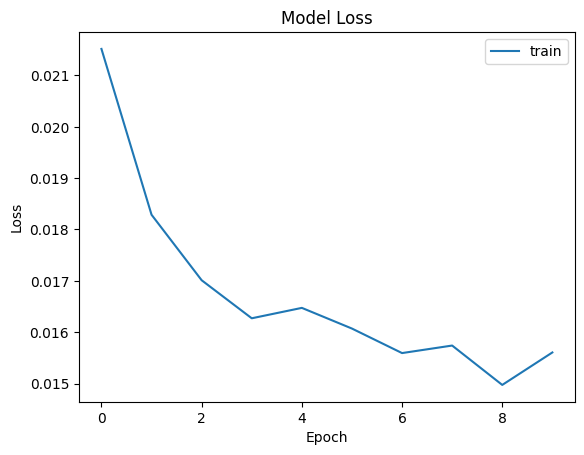

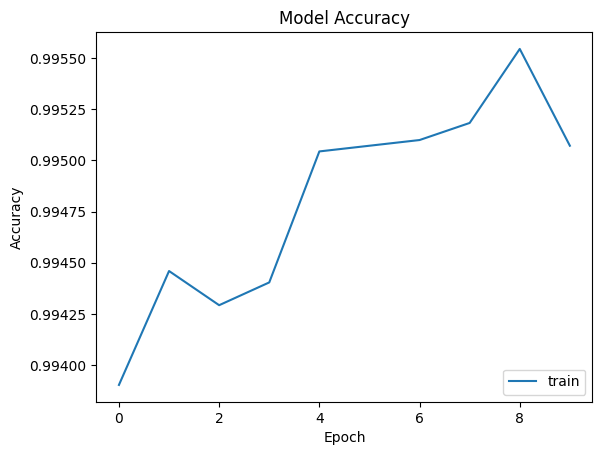

281/281 [==============================] - 2s 7ms/step


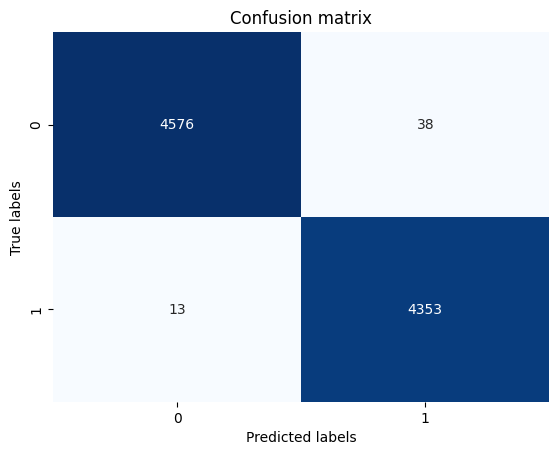

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4614
           1       0.99      1.00      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 29s 13ms/step - loss: 0.0224 - accuracy: 0.9930
Epoch 2/10
1796/1796 [==============================] - 34s 19ms/step - loss: 0.0184 - accuracy: 0.9943
Epoch 3/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0176 - accuracy: 0.9946
Epoch 4/10
1796/1796 [==============================] - 22s 12ms/step - loss: 0.0173 - accuracy: 0.9945
Epoch 5/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0172 - accuracy: 0.9946
Epoch 6/10
1796/1796 [==============================] - 25s 14ms/step - loss: 0.0167 - accuracy: 0.9946
Epoch 7/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0165 - accuracy: 0.9949
Epoch 8/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0167 - accuracy: 0.9947
Epoch 9/10
1796/1796 [==============================] - 23s 13ms/step - loss: 0.0162 - accuracy: 0.9948
Epoch 10/10
449/449 [==============================] - 2s 4ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.00)
Cross-Validation Loss: 0.02 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

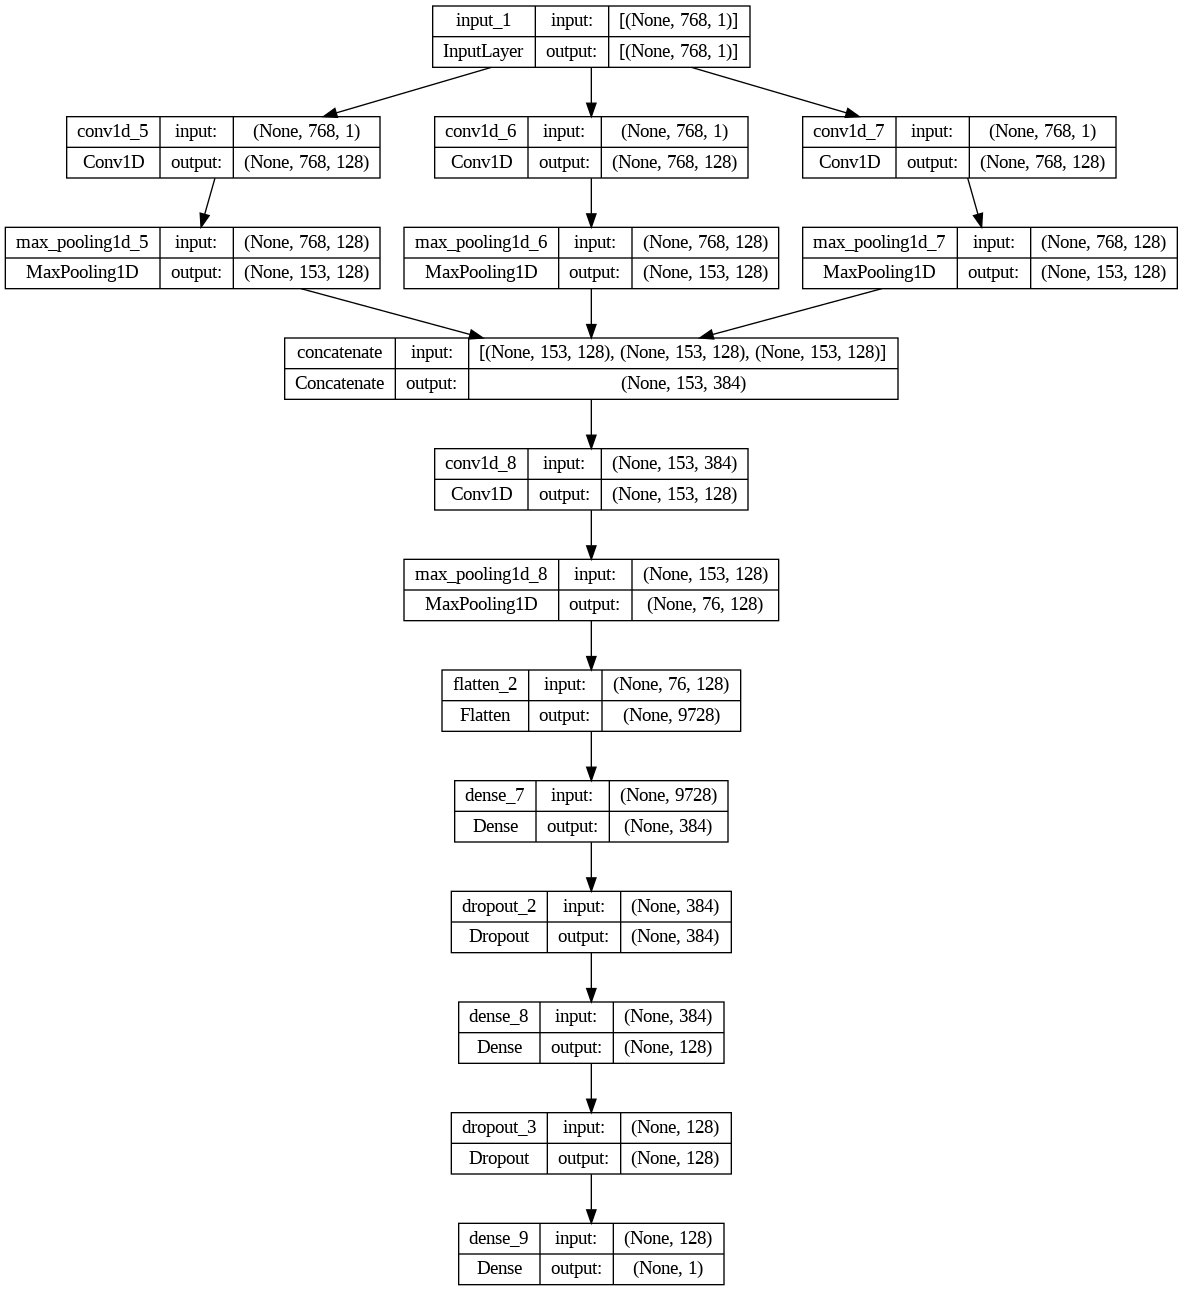

In [ ]:
plot_model(model3, to_file='model.png', show_shapes=True)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 20s 8ms/step - loss: 0.0277 - accuracy: 0.9933
Epoch 2/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0208 - accuracy: 0.9938
Epoch 3/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0187 - accuracy: 0.9943
Epoch 4/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0222 - accuracy: 0.9940
Epoch 5/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0185 - accuracy: 0.9947
Epoch 6/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0197 - accuracy: 0.9944
Epoch 7/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0177 - accuracy: 0.9947
Epoch 8/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0172 - accuracy: 0.9945
Epoch 9/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0176 - accuracy: 0.9944
Epoch 10/10
2245/2245 [==============================] - 17s 7ms/step - l

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0188 - accuracy: 0.9943 - 2s/epoch - 6ms/step
281/281 [==============================] - 1s 4ms/step
Test Accuracy: 0.9943206906318665
Test F1 Score: 0.9941667619810133
Test Recall: 0.9954191479615209
Precision: 0.9929175234178661


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

281/281 [==============================] - 1s 4ms/step
[[4583   31]
 [  20 4346]]


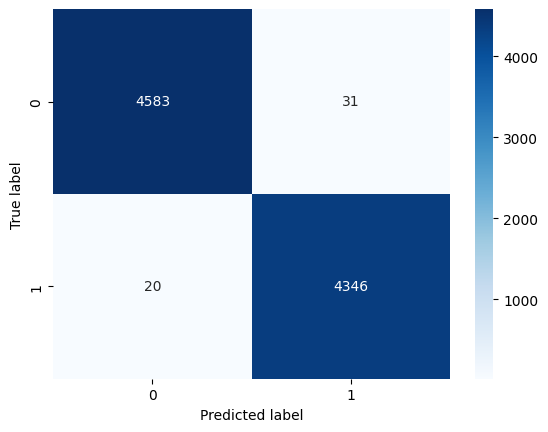

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 16s 8ms/step - loss: 0.0304 - accuracy: 0.9927
Epoch 2/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0203 - accuracy: 0.9941
Epoch 3/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0194 - accuracy: 0.9944
Epoch 4/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0181 - accuracy: 0.9943
Epoch 5/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0183 - accuracy: 0.9944
Epoch 6/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0196 - accuracy: 0.9945
Epoch 7/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0173 - accuracy: 0.9944
Epoch 8/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0188 - accuracy: 0.9944
Epoch 9/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0178 - accuracy: 0.9951
Epoch 10/10
449/449 [==============================] - 1s 3ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.01)
Cross-Validation Loss: 0.02 (+/- 0.00)
Cross-Validation Recall: 0.99 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

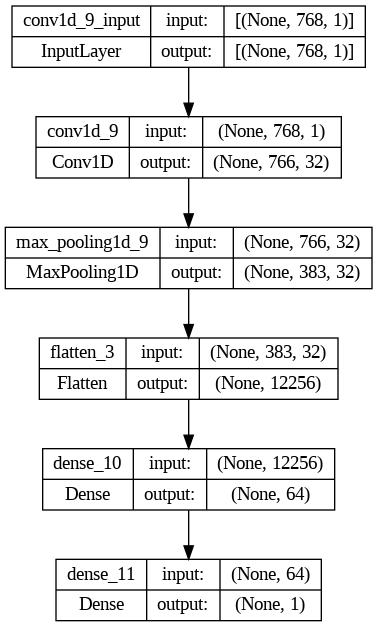

In [ ]:
plot_model(model4, to_file='model.png', show_shapes=True)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 11s 4ms/step - loss: 0.0193 - accuracy: 0.9941
Epoch 2/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0168 - accuracy: 0.9948
Epoch 3/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0164 - accuracy: 0.9947
Epoch 4/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0160 - accuracy: 0.9947
Epoch 5/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0155 - accuracy: 0.9949
Epoch 6/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0157 - accuracy: 0.9950
Epoch 7/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0154 - accuracy: 0.9951
Epoch 8/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0151 - accuracy: 0.9952
Epoch 9/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0155 - accuracy: 0.9951
Epoch 10/10
2245/2245 [==============================] - 10s 4ms/step - loss:

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9945434331893921
Test F1 Score: 0.9943993599268487
Test Recall: 0.9963353183692166
Precision: 0.9924709103353867


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

281/281 [==============================] - 0s 2ms/step
[[4581   33]
 [  16 4350]]


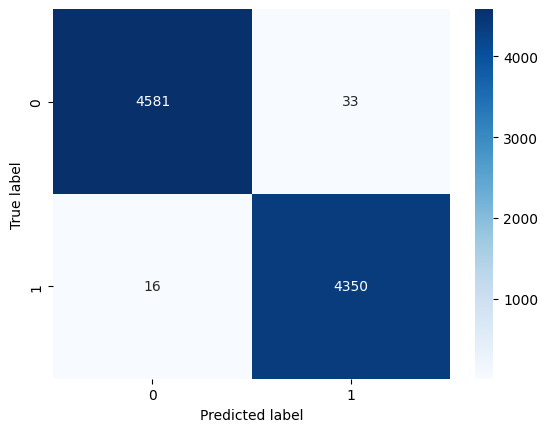

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

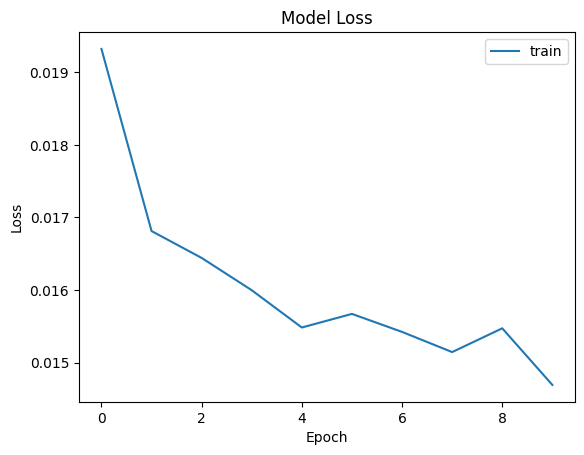

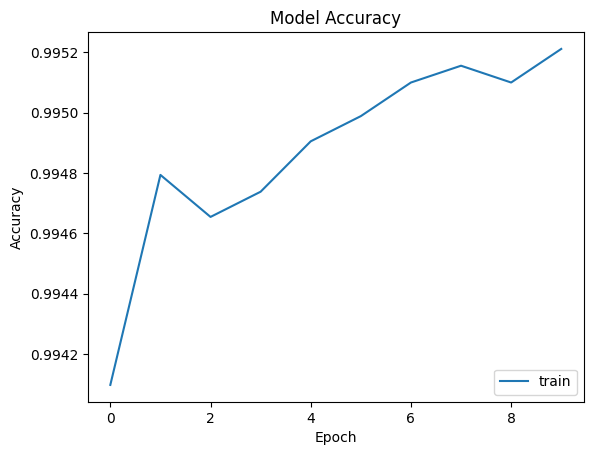

281/281 [==============================] - 1s 2ms/step


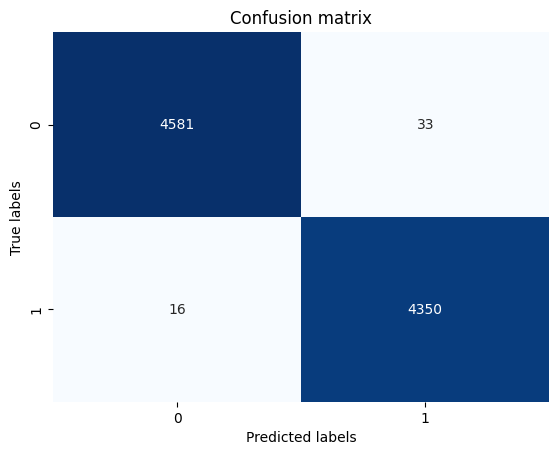

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4614
           1       0.99      1.00      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0197 - accuracy: 0.9944
Epoch 2/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0163 - accuracy: 0.9950
Epoch 3/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0161 - accuracy: 0.9953
Epoch 4/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0159 - accuracy: 0.9951
Epoch 5/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0149 - accuracy: 0.9953
Epoch 6/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0153 - accuracy: 0.9950
Epoch 7/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0150 - accuracy: 0.9953
Epoch 8/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0151 - accuracy: 0.9954
Epoch 9/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0151 - accuracy: 0.9953
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 1/10
1796

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.01)
Cross-Validation Loss: 0.02 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

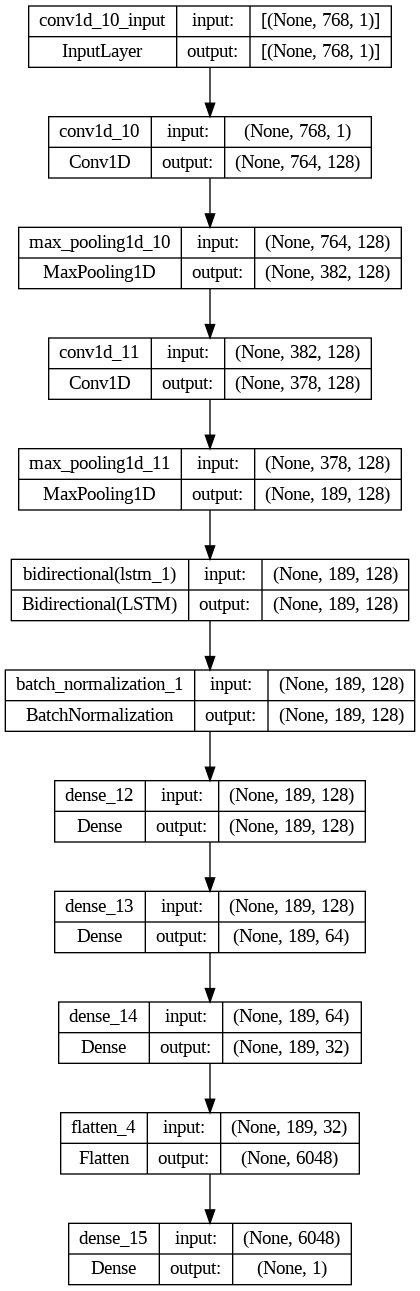

In [ ]:
plot_model(model5, to_file='model.png', show_shapes=True)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 49s 18ms/step - loss: 0.1068 - accuracy: 0.9942
Epoch 2/10
2245/2245 [==============================] - 43s 19ms/step - loss: 0.0215 - accuracy: 0.9947
Epoch 3/10
2245/2245 [==============================] - 44s 19ms/step - loss: 0.0195 - accuracy: 0.9948
Epoch 4/10
2245/2245 [==============================] - 44s 20ms/step - loss: 0.0190 - accuracy: 0.9947
Epoch 5/10
2245/2245 [==============================] - 44s 20ms/step - loss: 0.0183 - accuracy: 0.9951
Epoch 6/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0179 - accuracy: 0.9951
Epoch 7/10
2245/2245 [==============================] - 41s 18ms/step - loss: 0.0175 - accuracy: 0.9952
Epoch 8/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0170 - accuracy: 0.9954
Epoch 9/10
2245/2245 [==============================] - 43s 19ms/step - loss: 0.0170 - accuracy: 0.9953
Epoch 10/10
2245/2245 [==============================] - 43s 19m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 3s - loss: 0.0205 - accuracy: 0.9942 - 3s/epoch - 12ms/step
281/281 [==============================] - 4s 10ms/step
Test Accuracy: 0.994209349155426
Test F1 Score: 0.9940557841792409
Test Recall: 0.9958772331653688
Precision: 0.9922409858512095


In [ ]:
model5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                     

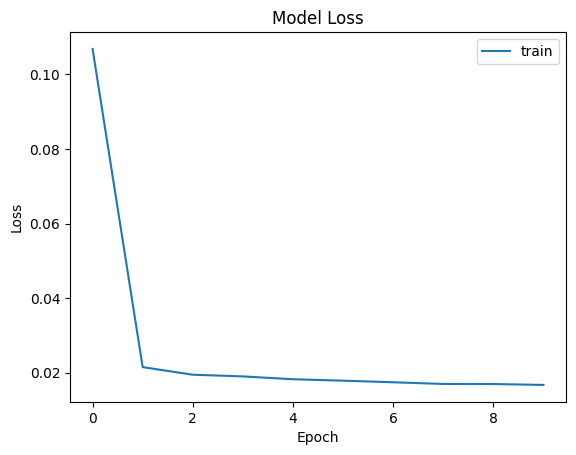

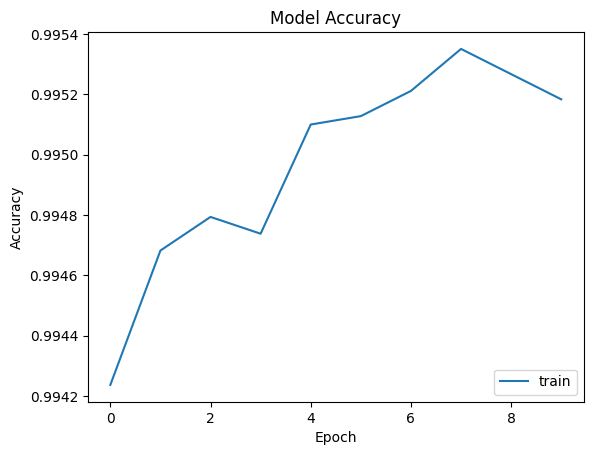

281/281 [==============================] - 3s 11ms/step


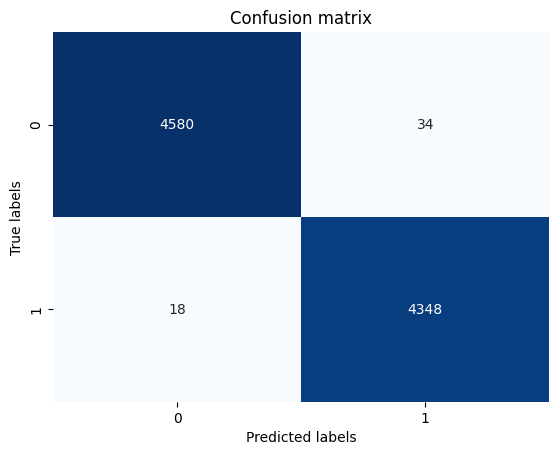

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4614
           1       0.99      1.00      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 40s 19ms/step - loss: 0.1246 - accuracy: 0.9944
Epoch 2/10
1796/1796 [==============================] - 35s 19ms/step - loss: 0.0217 - accuracy: 0.9949
Epoch 3/10
1796/1796 [==============================] - 33s 19ms/step - loss: 0.0206 - accuracy: 0.9948
Epoch 4/10
1796/1796 [==============================] - 33s 18ms/step - loss: 0.0190 - accuracy: 0.9949
Epoch 5/10
1796/1796 [==============================] - 33s 19ms/step - loss: 0.0185 - accuracy: 0.9953
Epoch 6/10
1796/1796 [==============================] - 35s 19ms/step - loss: 0.0180 - accuracy: 0.9952
Epoch 7/10
1796/1796 [==============================] - 34s 19ms/step - loss: 0.0174 - accuracy: 0.9951
Epoch 8/10
1796/1796 [==============================] - 33s 19ms/step - loss: 0.0174 - accuracy: 0.9951
Epoch 9/10
1796/1796 [==============================] - 33s 19ms/step - loss: 0.0173 - accuracy: 0.9952
Epoch 10/10
449/449 [==============================] - 3s 6ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.00)
Cross-Validation Loss: 0.02 (+/- 0.01)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

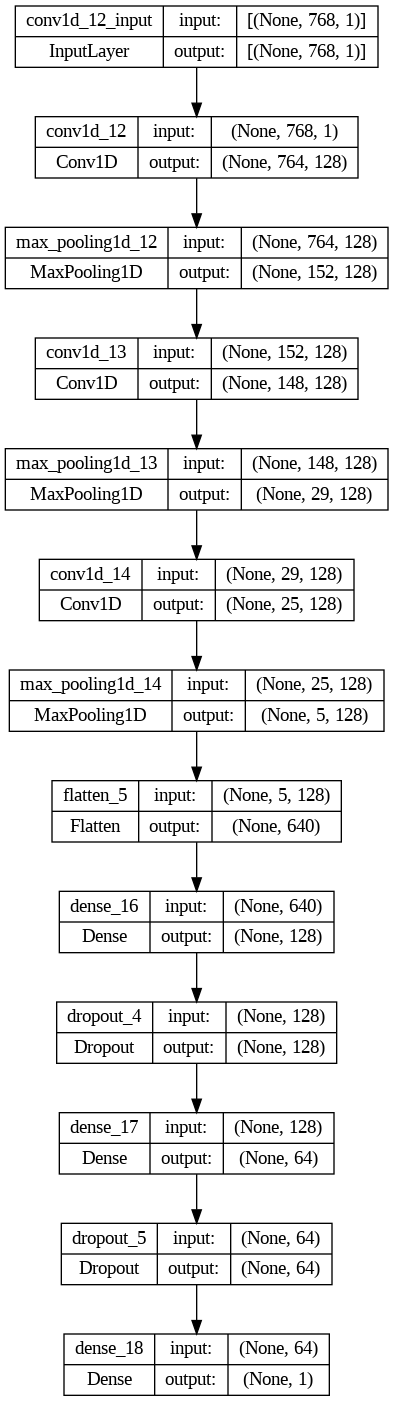

In [ ]:
plot_model(model6, to_file='model.png', show_shapes=True)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 16s 6ms/step - loss: 0.1161 - accuracy: 0.9915
Epoch 2/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0319 - accuracy: 0.9940
Epoch 3/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0285 - accuracy: 0.9933
Epoch 4/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0273 - accuracy: 0.9940
Epoch 5/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0275 - accuracy: 0.9943
Epoch 6/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0270 - accuracy: 0.9941
Epoch 7/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0263 - accuracy: 0.9944
Epoch 8/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0261 - accuracy: 0.9944
Epoch 9/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0252 - accuracy: 0.9945
Epoch 10/10
2245/2245 [==============================] - 14s 6ms/step - l

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9944320917129517
Test F1 Score: 0.9942726231386025
Test Recall: 0.9940448923499771
Precision: 0.9945004582951421


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_74 (MaxPoolin  (None, 5, 128)         

281/281 [==============================] - 1s 2ms/step
[[4590   24]
 [  26 4340]]


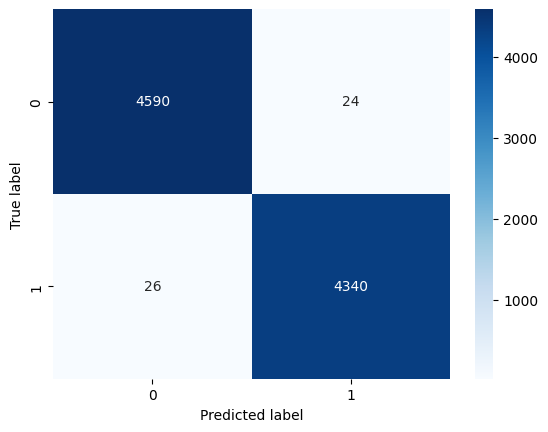

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

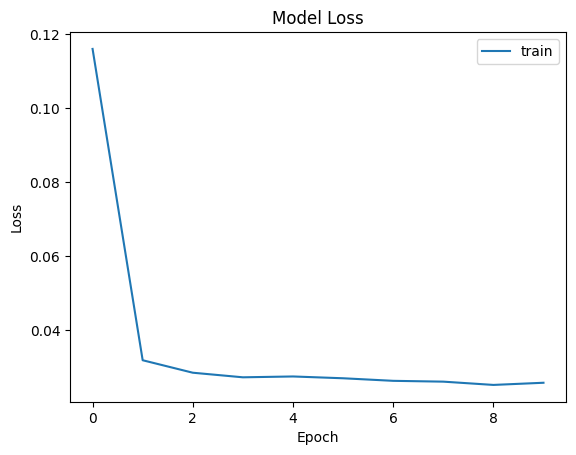

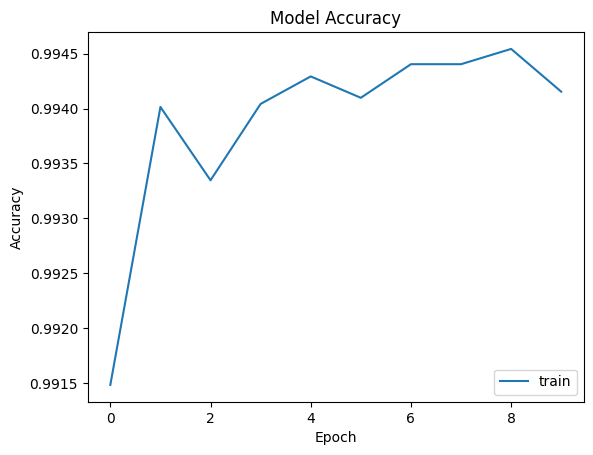

281/281 [==============================] - 1s 2ms/step


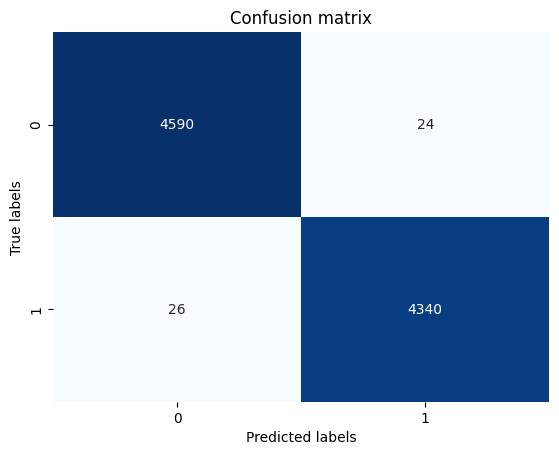

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4614
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 13s 6ms/step - loss: 0.1428 - accuracy: 0.9895
Epoch 2/10
1796/1796 [==============================] - 12s 6ms/step - loss: 0.0322 - accuracy: 0.9941
Epoch 3/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0300 - accuracy: 0.9941
Epoch 4/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0281 - accuracy: 0.9944
Epoch 5/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0264 - accuracy: 0.9944
Epoch 6/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0297 - accuracy: 0.9940
Epoch 7/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0258 - accuracy: 0.9943
Epoch 8/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0267 - accuracy: 0.9939
Epoch 9/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0259 - accuracy: 0.9943
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.00)
Cross-Validation Loss: 0.02 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


# Texts

## **CNN-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_text_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_text_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 21s 6ms/step - loss: 0.0120 - accuracy: 0.9976
Epoch 2/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0046 - accuracy: 0.9997
Epoch 3/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0052 - accuracy: 0.9997
Epoch 4/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0062 - accuracy: 0.9996
Epoch 5/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0029 - accuracy: 0.9997
Epoch 6/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0045 - accuracy: 0.9997
Epoch 7/10
2245/2245 [==============================] - 12s 6ms/step - loss: 0.0026 - accuracy: 0.9998
Epoch 8/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0041 - accuracy: 0.9997
Epoch 9/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0041 - accuracy: 0.9998
Epoch 10/10
2245/2245 [==============================] - 13s 6ms/step - l

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9995545744895935
Test F1 Score: 0.9995419147961521
Test Recall: 0.9995419147961521
Precision: 0.9995419147961521


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

281/281 [==============================] - 1s 2ms/step
[[4612    2]
 [   2 4364]]


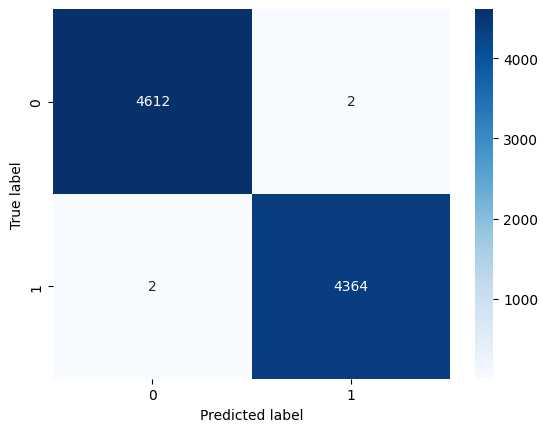

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    print(classification_report(test_labels, y_pred))

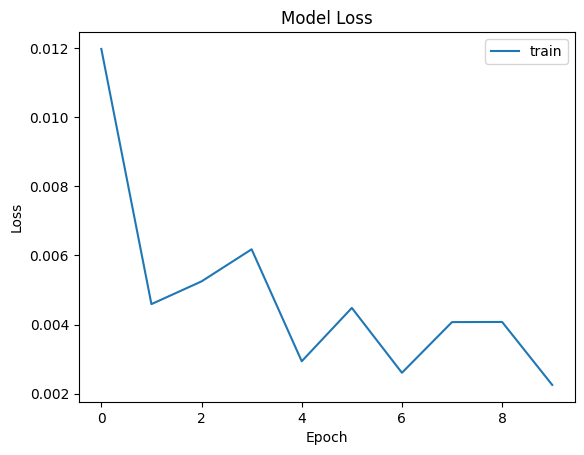

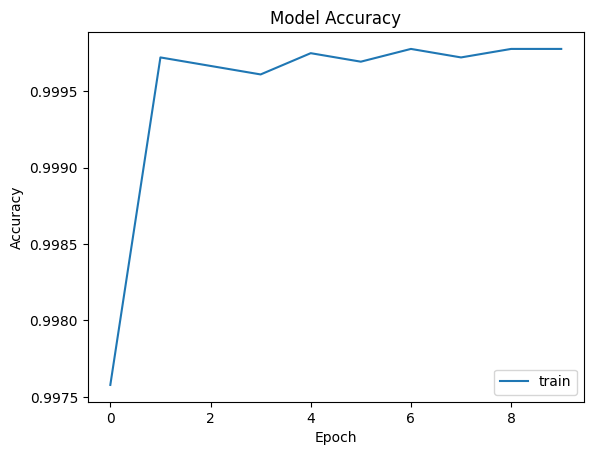

281/281 [==============================] - 1s 2ms/step


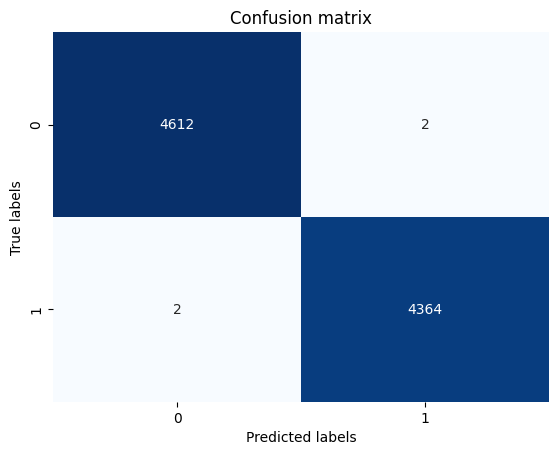

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      1.00      1.00      4366

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 13s 5ms/step - loss: 0.0122 - accuracy: 0.9974
Epoch 2/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0050 - accuracy: 0.9997
Epoch 3/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0045 - accuracy: 0.9996
Epoch 4/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0038 - accuracy: 0.9996
Epoch 5/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0054 - accuracy: 0.9996
Epoch 6/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0054 - accuracy: 0.9996
Epoch 7/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0059 - accuracy: 0.9995
Epoch 8/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0045 - accuracy: 0.9997
Epoch 9/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0040 - accuracy: 0.9998
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 1/

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 1.00 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.00 (+/- 0.01)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 1.00 (+/- 0.00)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 34s 13ms/step - loss: 0.0049 - accuracy: 0.9995
Epoch 2/10
2245/2245 [==============================] - 28s 13ms/step - loss: 0.0029 - accuracy: 0.9997
Epoch 3/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.0022 - accuracy: 0.9998
Epoch 4/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.0024 - accuracy: 0.9997
Epoch 5/10
2245/2245 [==============================] - 27s 12ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 6/10
2245/2245 [==============================] - 27s 12ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 7/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.0025 - accuracy: 0.9998
Epoch 8/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.0022 - accuracy: 0.9997
Epoch 9/10
2245/2245 [==============================] - 28s 13ms/step - loss: 0.0027 - accuracy: 0.9998
Epoch 10/10
2245/2245 [==============================] - 28s 12m

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 3s - loss: 0.0080 - accuracy: 0.9996 - 3s/epoch - 9ms/step
281/281 [==============================] - 2s 7ms/step
Test Accuracy: 0.9995545744895935
Test F1 Score: 0.9995419147961521
Test Recall: 0.9995419147961521
Precision: 0.9995419147961521


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

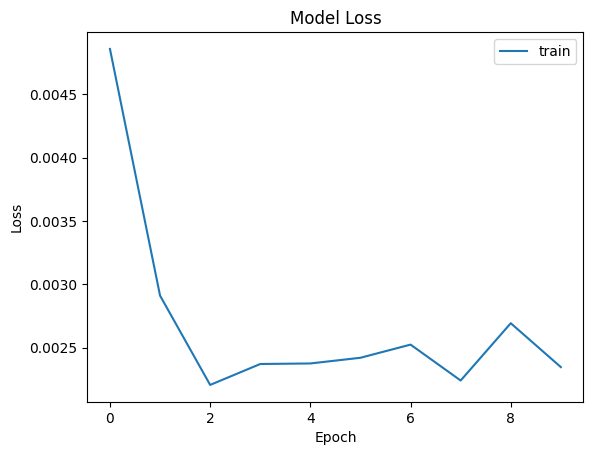

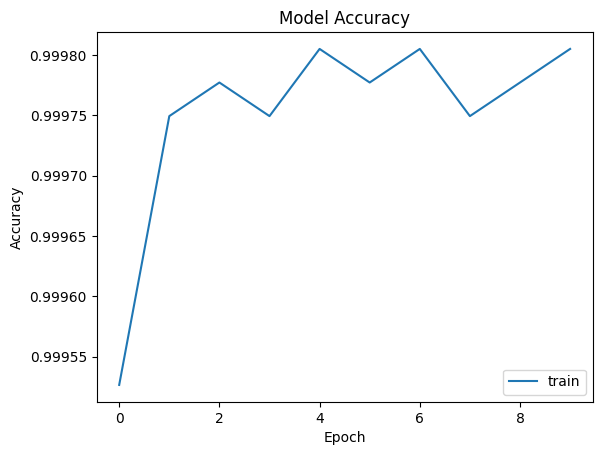

281/281 [==============================] - 2s 8ms/step


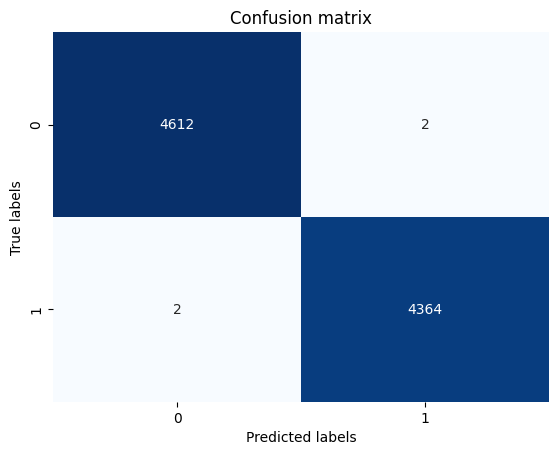

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      1.00      1.00      4366

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 26s 12ms/step - loss: 0.0036 - accuracy: 0.9995
Epoch 2/10
1796/1796 [==============================] - 23s 13ms/step - loss: 0.0020 - accuracy: 0.9998
Epoch 3/10
1796/1796 [==============================] - 21s 12ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 4/10
1796/1796 [==============================] - 23s 13ms/step - loss: 0.0018 - accuracy: 0.9999
Epoch 5/10
1796/1796 [==============================] - 21s 12ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 6/10
1796/1796 [==============================] - 23s 13ms/step - loss: 0.0015 - accuracy: 0.9998
Epoch 7/10
1796/1796 [==============================] - 21s 12ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 8/10
1796/1796 [==============================] - 23s 13ms/step - loss: 0.0017 - accuracy: 0.9999
Epoch 9/10
1796/1796 [==============================] - 21s 12ms/step - loss: 0.0018 - accuracy: 0.9999
Epoch 10/10
449/449 [==============================] - 2s 4ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 1.00 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.00 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 1.00 (+/- 0.00)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 29s 8ms/step - loss: 0.0080 - accuracy: 0.9985
Epoch 2/10
2245/2245 [==============================] - 17s 7ms/step - loss: 0.0066 - accuracy: 0.9995
Epoch 3/10
2245/2245 [==============================] - 17s 7ms/step - loss: 0.0035 - accuracy: 0.9996
Epoch 4/10
2245/2245 [==============================] - 17s 7ms/step - loss: 0.0041 - accuracy: 0.9998
Epoch 5/10
2245/2245 [==============================] - 17s 7ms/step - loss: 0.0048 - accuracy: 0.9998
Epoch 6/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0044 - accuracy: 0.9997
Epoch 7/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0040 - accuracy: 0.9997
Epoch 8/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0033 - accuracy: 0.9998
Epoch 9/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0030 - accuracy: 0.9998
Epoch 10/10
2245/2245 [==============================] - 17s 8ms/step - l

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0051 - accuracy: 0.9996 - 2s/epoch - 6ms/step
281/281 [==============================] - 1s 4ms/step
Test Accuracy: 0.9995545744895935
Test F1 Score: 0.9995419147961521
Test Recall: 0.9995419147961521
Precision: 0.9995419147961521


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 768, 128)     512         ['input_2[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 768, 128)     640         ['input_2[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 768, 128)     768         ['input_2[0][0]']                
                                                                                            

281/281 [==============================] - 1s 3ms/step
[[4612    2]
 [   2 4364]]


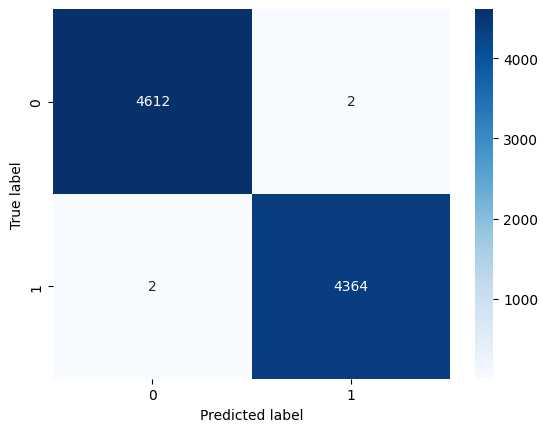

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 16s 8ms/step - loss: 0.0097 - accuracy: 0.9985
Epoch 2/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0066 - accuracy: 0.9995
Epoch 3/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0044 - accuracy: 0.9998
Epoch 4/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0042 - accuracy: 0.9997
Epoch 5/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0042 - accuracy: 0.9998
Epoch 6/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0048 - accuracy: 0.9998
Epoch 7/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0029 - accuracy: 0.9998
Epoch 8/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0028 - accuracy: 0.9998
Epoch 9/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0030 - accuracy: 0.9998
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 1.00 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.00 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 1.00 (+/- 0.00)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0036 - accuracy: 0.9995
Epoch 2/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 3/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0022 - accuracy: 0.9998
Epoch 4/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 5/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0020 - accuracy: 0.9998
Epoch 6/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 7/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 8/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 9/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 10/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.00

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9995545744895935
Test F1 Score: 0.9995419147961521
Test Recall: 0.9995419147961521
Precision: 0.9995419147961521


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

281/281 [==============================] - 0s 2ms/step
[[4612    2]
 [   2 4364]]


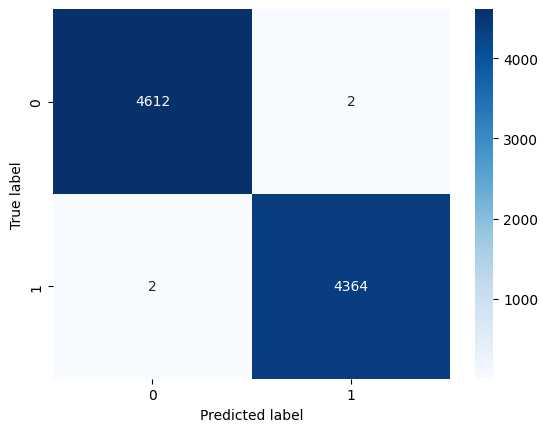

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

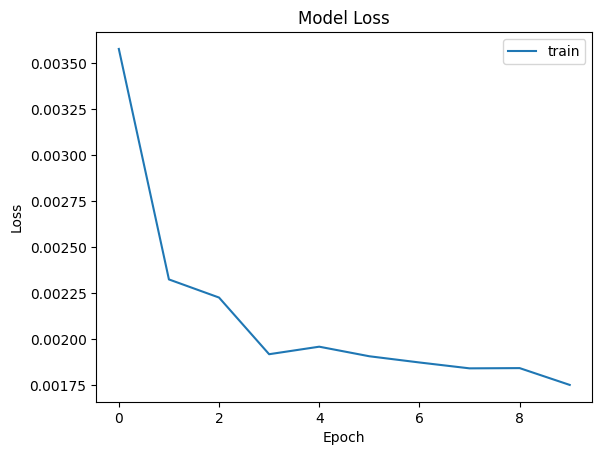

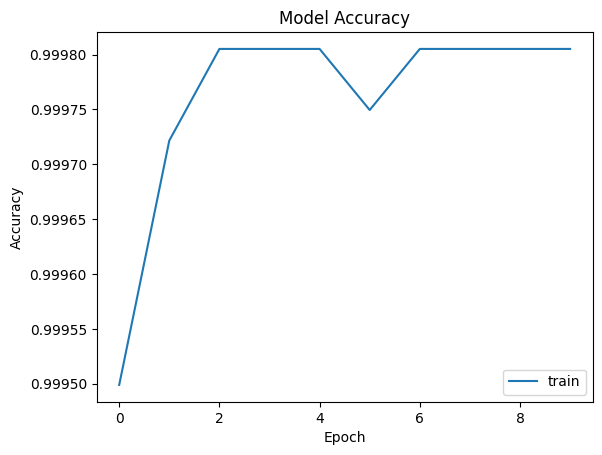

281/281 [==============================] - 1s 2ms/step


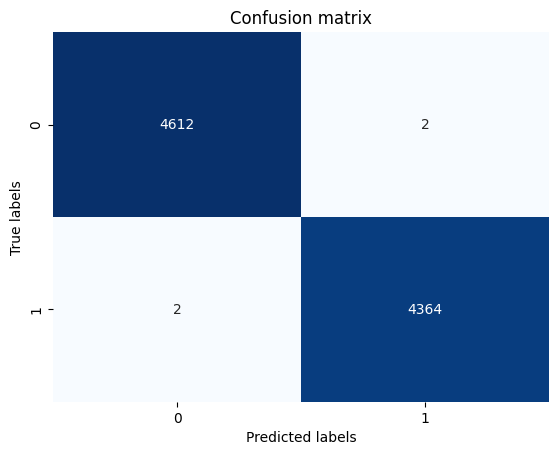

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      1.00      1.00      4366

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0030 - accuracy: 0.9994
Epoch 2/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 3/10
1796/1796 [==============================] - 6s 4ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 4/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 5/10
1796/1796 [==============================] - 6s 4ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 6/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 7/10
1796/1796 [==============================] - 6s 4ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 8/10
1796/1796 [==============================] - 8s 4ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 9/10
1796/1796 [==============================] - 6s 3ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 1/10
1796

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 1.00 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.00 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 1.00 (+/- 0.00)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 50s 19ms/step - loss: 0.0870 - accuracy: 0.9994
Epoch 2/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0051 - accuracy: 0.9997
Epoch 3/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0055 - accuracy: 0.9998
Epoch 4/10
2245/2245 [==============================] - 43s 19ms/step - loss: 0.0053 - accuracy: 0.9997
Epoch 5/10
2245/2245 [==============================] - 44s 20ms/step - loss: 0.0049 - accuracy: 0.9998
Epoch 6/10
2245/2245 [==============================] - 44s 19ms/step - loss: 0.0046 - accuracy: 0.9998
Epoch 7/10
2245/2245 [==============================] - 44s 19ms/step - loss: 0.0054 - accuracy: 0.9998
Epoch 8/10
2245/2245 [==============================] - 44s 20ms/step - loss: 0.0045 - accuracy: 0.9998
Epoch 9/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0073 - accuracy: 0.9996
Epoch 10/10
2245/2245 [==============================] - 42s 19m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 4s - loss: 0.0052 - accuracy: 0.9996 - 4s/epoch - 15ms/step
281/281 [==============================] - 3s 9ms/step
Test Accuracy: 0.9995545744895935
Test F1 Score: 0.9995419147961521
Test Recall: 0.9995419147961521
Precision: 0.9995419147961521


In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 764, 128)          768       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 382, 128)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 378, 128)          82048     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 189, 128)         0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                        

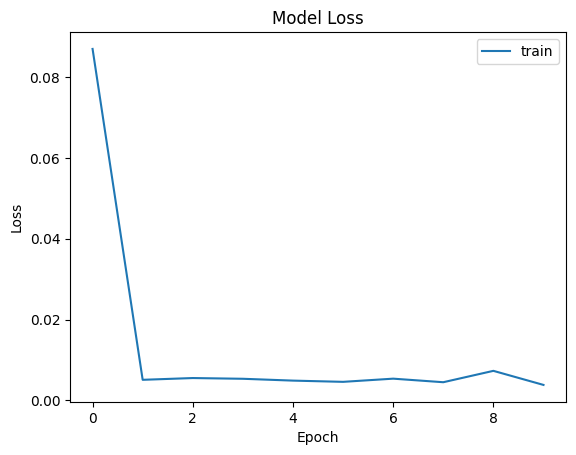

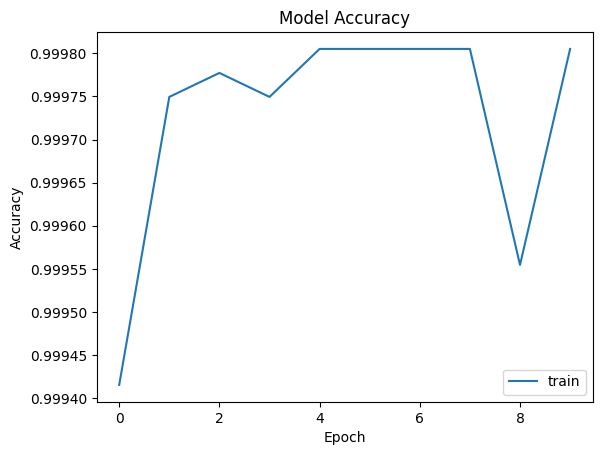

281/281 [==============================] - 3s 9ms/step


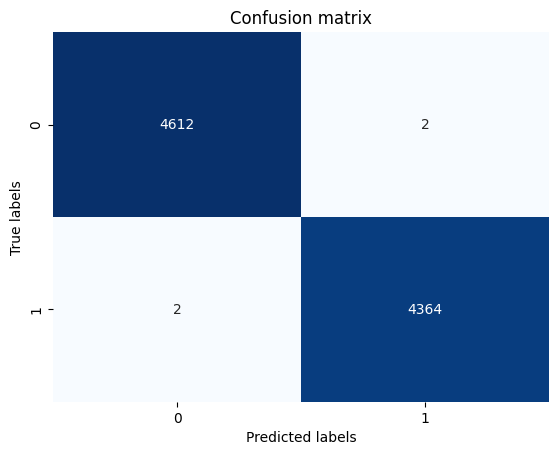

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      1.00      1.00      4366

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 41s 19ms/step - loss: 0.1021 - accuracy: 0.9994
Epoch 2/10
1796/1796 [==============================] - 33s 19ms/step - loss: 0.0058 - accuracy: 0.9997
Epoch 3/10
1796/1796 [==============================] - 35s 19ms/step - loss: 0.0053 - accuracy: 0.9998
Epoch 4/10
1796/1796 [==============================] - 43s 24ms/step - loss: 0.0052 - accuracy: 0.9998
Epoch 5/10
1796/1796 [==============================] - 34s 19ms/step - loss: 0.0046 - accuracy: 0.9998
Epoch 6/10
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0040 - accuracy: 0.9998
Epoch 7/10
1796/1796 [==============================] - 34s 19ms/step - loss: 0.0039 - accuracy: 0.9998
Epoch 8/10
1796/1796 [==============================] - 33s 18ms/step - loss: 0.0039 - accuracy: 0.9998
Epoch 9/10
1796/1796 [==============================] - 33s 19ms/step - loss: 0.0041 - accuracy: 0.9998
Epoch 10/10
449/449 [==============================] - 3s 7ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 1.00 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.00 (+/- 0.00)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 1.00 (+/- 0.00)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 16s 6ms/step - loss: 0.0911 - accuracy: 0.9976
Epoch 2/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0103 - accuracy: 0.9996
Epoch 3/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0081 - accuracy: 0.9996
Epoch 4/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0096 - accuracy: 0.9997
Epoch 5/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0089 - accuracy: 0.9996
Epoch 6/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0081 - accuracy: 0.9995
Epoch 7/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0081 - accuracy: 0.9996
Epoch 8/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0086 - accuracy: 0.9996
Epoch 9/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0083 - accuracy: 0.9996
Epoch 10/10
2245/2245 [==============================] - 13s 6ms/step - l

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9995545744895935
Test F1 Score: 0.9995419147961521
Test Recall: 0.9995419147961521
Precision: 0.9995419147961521


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 5, 128)          

281/281 [==============================] - 1s 2ms/step
[[4612    2]
 [   2 4364]]


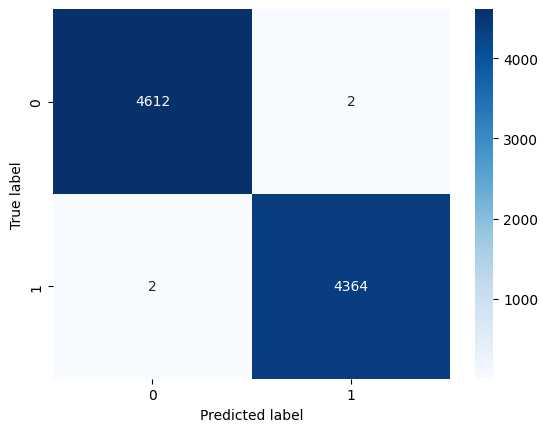

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

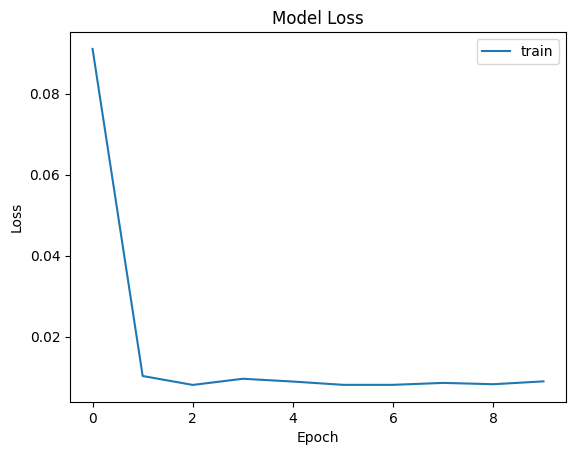

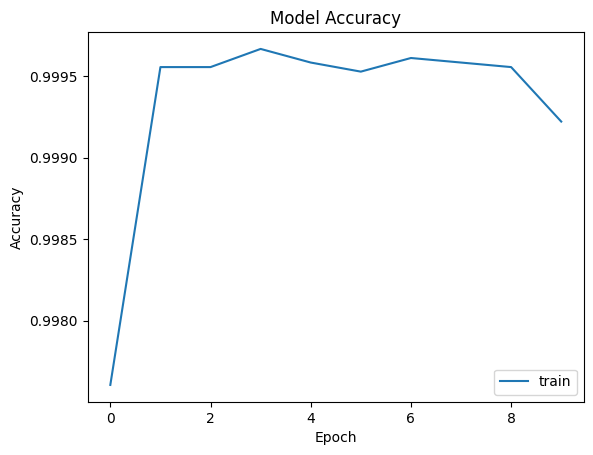

281/281 [==============================] - 1s 2ms/step


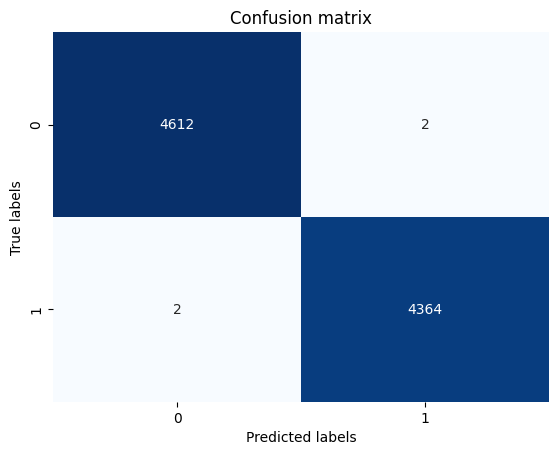

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      1.00      1.00      4366

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 13s 6ms/step - loss: 0.1130 - accuracy: 0.9965
Epoch 2/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0148 - accuracy: 0.9988
Epoch 3/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0113 - accuracy: 0.9989
Epoch 4/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0082 - accuracy: 0.9996
Epoch 5/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0100 - accuracy: 0.9995
Epoch 6/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0094 - accuracy: 0.9994
Epoch 7/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0091 - accuracy: 0.9995
Epoch 8/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0072 - accuracy: 0.9997
Epoch 9/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0078 - accuracy: 0.9993
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 1/1

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 1.00 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.00 (+/- 0.01)
Cross-Validation Recall: 1.00 (+/- 0.00)
Cross-Validation F1 Score: 1.00 (+/- 0.00)


# Max Worth

## **CNN-DistilBERT**

In [ ]:
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_textmax_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_textmax_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 45s 12ms/step - loss: 0.0599 - accuracy: 0.9879
Epoch 2/10
2245/2245 [==============================] - 21s 9ms/step - loss: 0.0466 - accuracy: 0.9899
Epoch 3/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0458 - accuracy: 0.9895
Epoch 4/10
2245/2245 [==============================] - 15s 7ms/step - loss: 0.0435 - accuracy: 0.9895
Epoch 5/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0428 - accuracy: 0.9898
Epoch 6/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0392 - accuracy: 0.9902
Epoch 7/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0386 - accuracy: 0.9899
Epoch 8/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0353 - accuracy: 0.9897
Epoch 9/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0343 - accuracy: 0.9896
Epoch 10/10
2245/2245 [==============================] - 14s 6ms/step - 

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 3ms/step
Test Accuracy: 0.9897550344467163
Test F1 Score: 0.9893592412676382
Test Recall: 0.9796152084287677
Precision: 0.9992990654205608


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

281/281 [==============================] - 1s 2ms/step
[[4611    3]
 [  89 4277]]


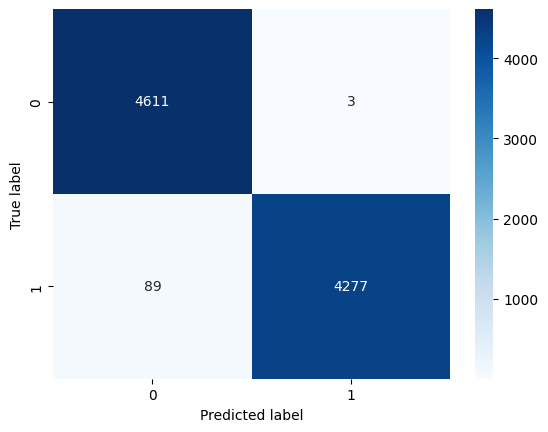

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

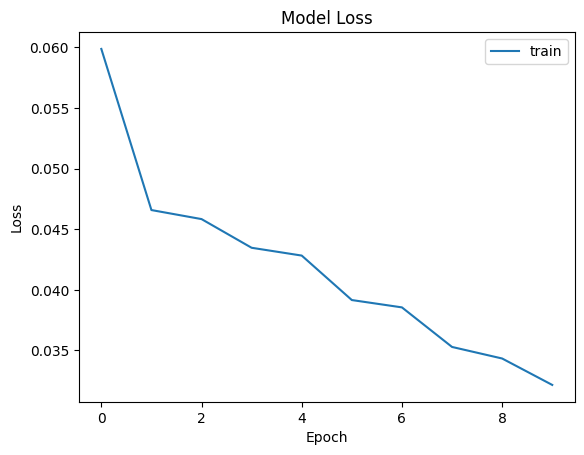

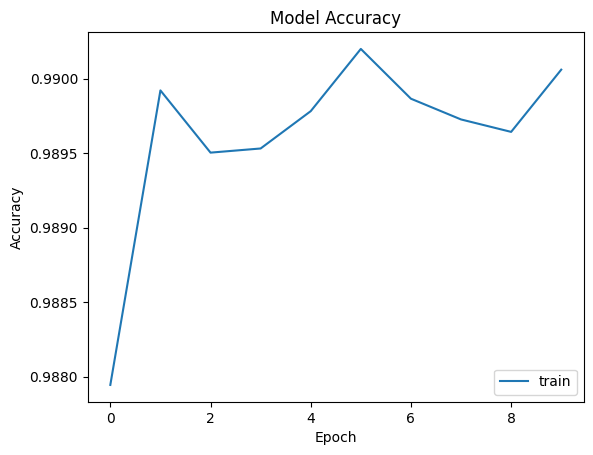

281/281 [==============================] - 1s 2ms/step


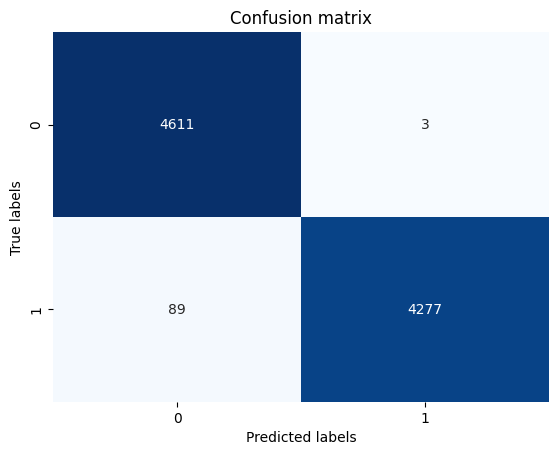

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4614
           1       1.00      0.98      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model1 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model1, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 14s 6ms/step - loss: 0.0608 - accuracy: 0.9868
Epoch 2/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0490 - accuracy: 0.9902
Epoch 3/10
1796/1796 [==============================] - 12s 7ms/step - loss: 0.0449 - accuracy: 0.9900
Epoch 4/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0422 - accuracy: 0.9899
Epoch 5/10
1796/1796 [==============================] - 12s 7ms/step - loss: 0.0423 - accuracy: 0.9904
Epoch 6/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0428 - accuracy: 0.9898
Epoch 7/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0403 - accuracy: 0.9904
Epoch 8/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0384 - accuracy: 0.9905
Epoch 9/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0362 - accuracy: 0.9898
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.03 (+/- 0.01)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 35s 14ms/step - loss: 0.0440 - accuracy: 0.9894
Epoch 2/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0399 - accuracy: 0.9898
Epoch 3/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0370 - accuracy: 0.9899
Epoch 4/10
2245/2245 [==============================] - 32s 14ms/step - loss: 0.0335 - accuracy: 0.9897
Epoch 5/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0315 - accuracy: 0.9896
Epoch 6/10
2245/2245 [==============================] - 32s 14ms/step - loss: 0.0296 - accuracy: 0.9903
Epoch 7/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0284 - accuracy: 0.9901
Epoch 8/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0278 - accuracy: 0.9900
Epoch 9/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0271 - accuracy: 0.9903
Epoch 10/10
2245/2245 [==============================] - 30s 13m

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 3s - loss: 0.0516 - accuracy: 0.9900 - 3s/epoch - 9ms/step
281/281 [==============================] - 2s 7ms/step
Test Accuracy: 0.9899777173995972
Test F1 Score: 0.9896337249481686
Test Recall: 0.9839670178653229
Precision: 0.995366079703429


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

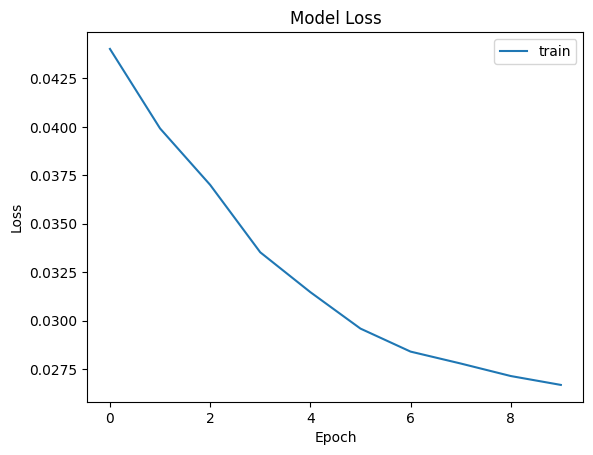

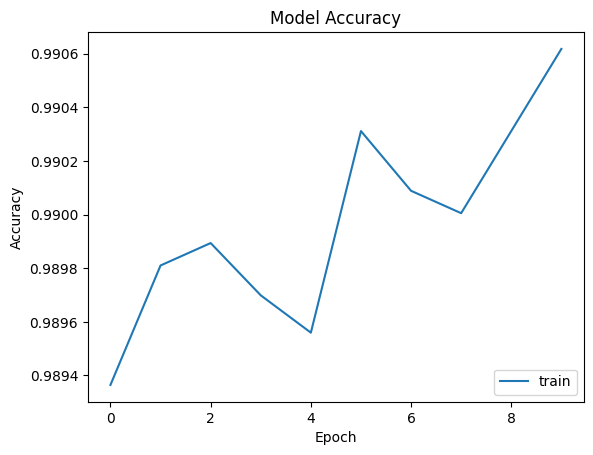

281/281 [==============================] - 2s 8ms/step


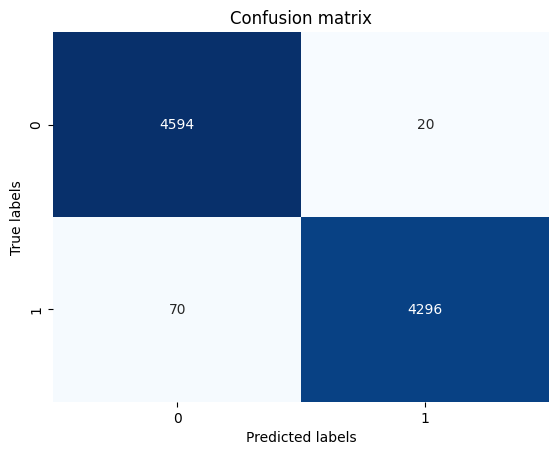

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4614
           1       1.00      0.98      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 28s 13ms/step - loss: 0.0438 - accuracy: 0.9904
Epoch 2/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0400 - accuracy: 0.9904
Epoch 3/10
1796/1796 [==============================] - 25s 14ms/step - loss: 0.0385 - accuracy: 0.9900
Epoch 4/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0367 - accuracy: 0.9903
Epoch 5/10
1796/1796 [==============================] - 28s 15ms/step - loss: 0.0347 - accuracy: 0.9905
Epoch 6/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0341 - accuracy: 0.9900
Epoch 7/10
1796/1796 [==============================] - 24s 13ms/step - loss: 0.0318 - accuracy: 0.9901
Epoch 8/10
1796/1796 [==============================] - 24s 14ms/step - loss: 0.0318 - accuracy: 0.9903
Epoch 9/10
1796/1796 [==============================] - 23s 13ms/step - loss: 0.0303 - accuracy: 0.9903
Epoch 10/10
449/449 [==============================] - 2s 4ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.03 (+/- 0.02)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 23s 8ms/step - loss: 0.0568 - accuracy: 0.9888
Epoch 2/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0452 - accuracy: 0.9894
Epoch 3/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0439 - accuracy: 0.9897
Epoch 4/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0433 - accuracy: 0.9897
Epoch 5/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0385 - accuracy: 0.9900
Epoch 6/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0371 - accuracy: 0.9896
Epoch 7/10
2245/2245 [==============================] - 18s 8ms/step - loss: 0.0347 - accuracy: 0.9899
Epoch 8/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0307 - accuracy: 0.9897
Epoch 9/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0367 - accuracy: 0.9901
Epoch 10/10
2245/2245 [==============================] - 17s 8ms/step - l

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0370 - accuracy: 0.9904 - 2s/epoch - 5ms/step
281/281 [==============================] - 1s 4ms/step
Test Accuracy: 0.9904231429100037
Test F1 Score: 0.9900669900669901
Test Recall: 0.9816765918460834
Precision: 0.9986020503261882


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

281/281 [==============================] - 1s 4ms/step
[[4608    6]
 [  80 4286]]


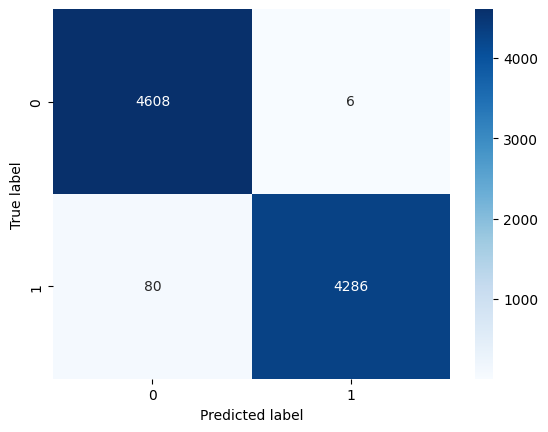

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 16s 8ms/step - loss: 0.0555 - accuracy: 0.9893
Epoch 2/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0473 - accuracy: 0.9897
Epoch 3/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0431 - accuracy: 0.9897
Epoch 4/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0435 - accuracy: 0.9902
Epoch 5/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0363 - accuracy: 0.9897
Epoch 6/10
1796/1796 [==============================] - 13s 7ms/step - loss: 0.0331 - accuracy: 0.9903
Epoch 7/10
1796/1796 [==============================] - 13s 8ms/step - loss: 0.0326 - accuracy: 0.9904
Epoch 8/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0311 - accuracy: 0.9896
Epoch 9/10
1796/1796 [==============================] - 14s 8ms/step - loss: 0.0301 - accuracy: 0.9898
Epoch 10/10
449/449 [==============================] - 2s 3ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 1.00 (+/- 0.00)
Cross-Validation Loss: 0.03 (+/- 0.01)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 11s 4ms/step - loss: 0.0445 - accuracy: 0.9898
Epoch 2/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0388 - accuracy: 0.9901
Epoch 3/10
2245/2245 [==============================] - 11s 5ms/step - loss: 0.0368 - accuracy: 0.9897
Epoch 4/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0342 - accuracy: 0.9901
Epoch 5/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0317 - accuracy: 0.9895
Epoch 6/10
2245/2245 [==============================] - 11s 5ms/step - loss: 0.0290 - accuracy: 0.9898
Epoch 7/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0281 - accuracy: 0.9906
Epoch 8/10
2245/2245 [==============================] - 10s 5ms/step - loss: 0.0277 - accuracy: 0.9903
Epoch 9/10
2245/2245 [==============================] - 10s 5ms/step - loss: 0.0272 - accuracy: 0.9902
Epoch 10/10
2245/2245 [==============================] - 9s 4ms/step - loss:

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9904231429100037
Test F1 Score: 0.9901240238860817
Test Recall: 0.9874026568941823
Precision: 0.9928604329801934


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

281/281 [==============================] - 1s 2ms/step
[[4583   31]
 [  55 4311]]


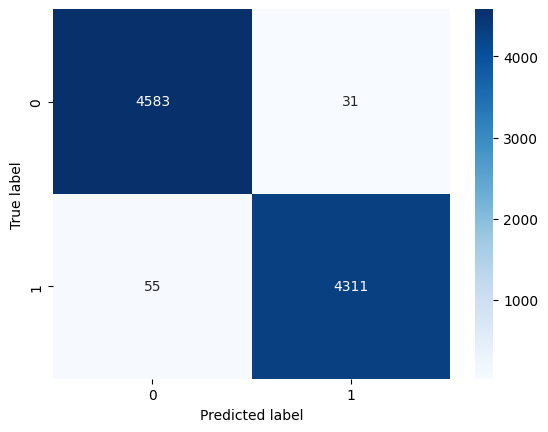

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

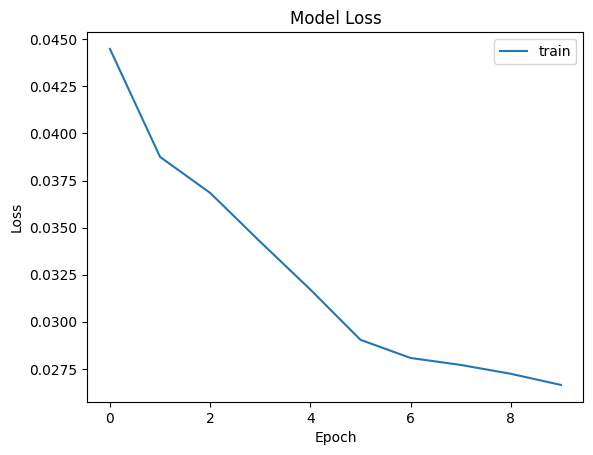

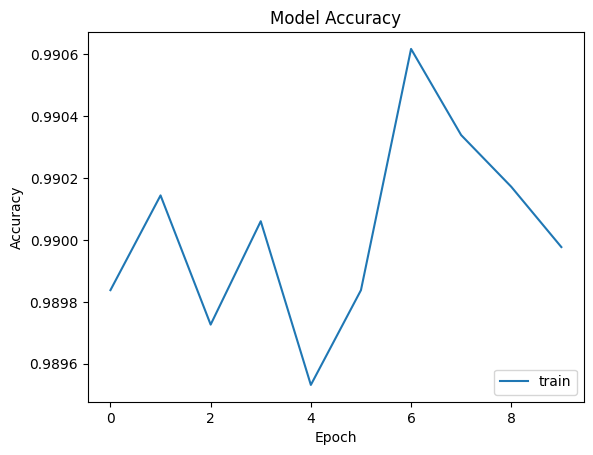

281/281 [==============================] - 1s 2ms/step


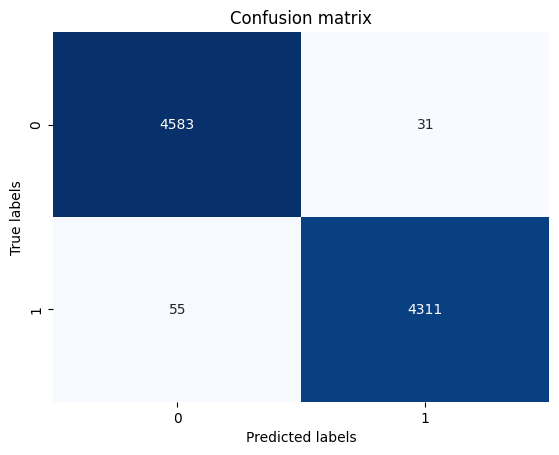

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4614
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0460 - accuracy: 0.9888
Epoch 2/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0400 - accuracy: 0.9900
Epoch 3/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0380 - accuracy: 0.9897
Epoch 4/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0372 - accuracy: 0.9895
Epoch 5/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0345 - accuracy: 0.9900
Epoch 6/10
1796/1796 [==============================] - 7s 4ms/step - loss: 0.0324 - accuracy: 0.9896
Epoch 7/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0307 - accuracy: 0.9902
Epoch 8/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0303 - accuracy: 0.9903
Epoch 9/10
1796/1796 [==============================] - 9s 5ms/step - loss: 0.0282 - accuracy: 0.9902
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 1/10
179

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.01)
Cross-Validation Loss: 0.03 (+/- 0.00)
Cross-Validation Recall: 0.99 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 70s 20ms/step - loss: 0.1394 - accuracy: 0.9898
Epoch 2/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0442 - accuracy: 0.9902
Epoch 3/10
2245/2245 [==============================] - 47s 21ms/step - loss: 0.0415 - accuracy: 0.9895
Epoch 4/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0393 - accuracy: 0.9900
Epoch 5/10
2245/2245 [==============================] - 42s 18ms/step - loss: 0.0371 - accuracy: 0.9901
Epoch 6/10
2245/2245 [==============================] - 41s 18ms/step - loss: 0.0341 - accuracy: 0.9901
Epoch 7/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0322 - accuracy: 0.9901
Epoch 8/10
2245/2245 [==============================] - 41s 18ms/step - loss: 0.0312 - accuracy: 0.9899
Epoch 9/10
2245/2245 [==============================] - 42s 19ms/step - loss: 0.0306 - accuracy: 0.9900
Epoch 10/10
2245/2245 [==============================] - 40s 18m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 4s - loss: 0.0337 - accuracy: 0.9900 - 4s/epoch - 15ms/step
281/281 [==============================] - 3s 9ms/step
Test Accuracy: 0.9899777173995972
Test F1 Score: 0.9896097898868621
Test Recall: 0.9816765918460834
Precision: 0.9976722532588455


In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 382, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 378, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 189, 128)         0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                        

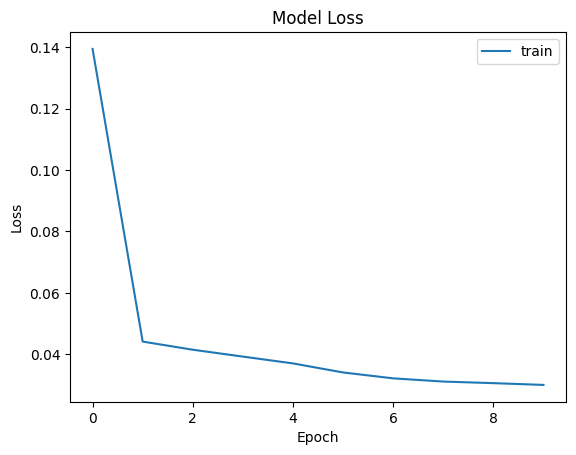

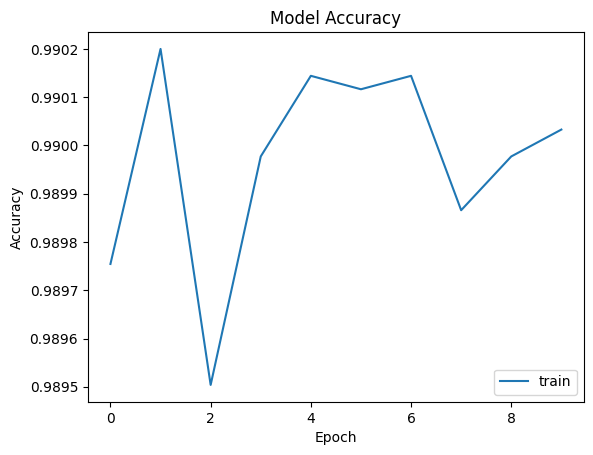

281/281 [==============================] - 3s 9ms/step


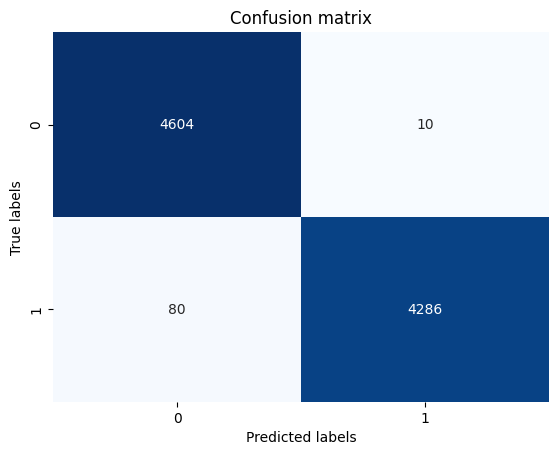

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4614
           1       1.00      0.98      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 39s 18ms/step - loss: 0.1604 - accuracy: 0.9890
Epoch 2/10
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0470 - accuracy: 0.9891
Epoch 3/10
1796/1796 [==============================] - 33s 18ms/step - loss: 0.0449 - accuracy: 0.9894
Epoch 4/10
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0428 - accuracy: 0.9897
Epoch 5/10
1796/1796 [==============================] - 33s 18ms/step - loss: 0.0407 - accuracy: 0.9894
Epoch 6/10
1796/1796 [==============================] - 33s 18ms/step - loss: 0.0380 - accuracy: 0.9899
Epoch 7/10
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0367 - accuracy: 0.9897
Epoch 8/10
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0353 - accuracy: 0.9895
Epoch 9/10
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0341 - accuracy: 0.9894
Epoch 10/10
449/449 [==============================] - 4s 9ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.01)
Cross-Validation Loss: 0.03 (+/- 0.01)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 16s 6ms/step - loss: 0.1482 - accuracy: 0.9881
Epoch 2/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0565 - accuracy: 0.9899
Epoch 3/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0551 - accuracy: 0.9896
Epoch 4/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0532 - accuracy: 0.9895
Epoch 5/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0536 - accuracy: 0.9896
Epoch 6/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0531 - accuracy: 0.9900
Epoch 7/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0518 - accuracy: 0.9896
Epoch 8/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0514 - accuracy: 0.9895
Epoch 9/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0491 - accuracy: 0.9893
Epoch 10/10
2245/2245 [==============================] - 13s 6ms/step - l

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9895322918891907
Test F1 Score: 0.9891254049051365
Test Recall: 0.9791571232249199
Precision: 0.9992987377279102


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 5, 128)          

281/281 [==============================] - 1s 2ms/step
[[4611    3]
 [  91 4275]]


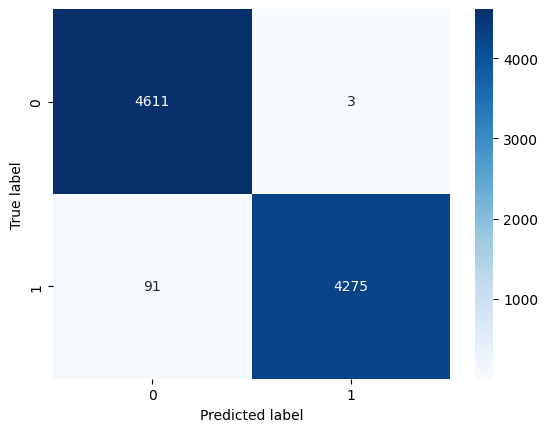

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

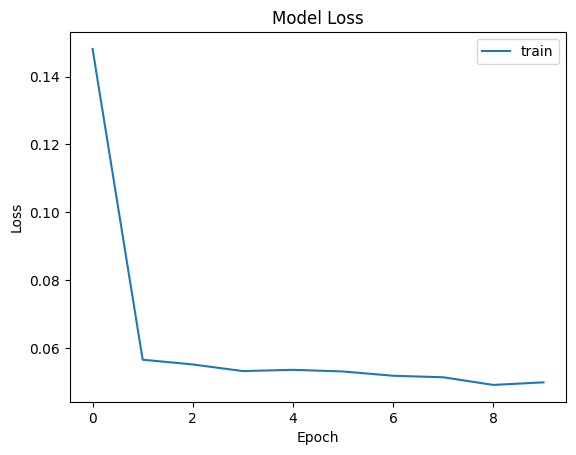

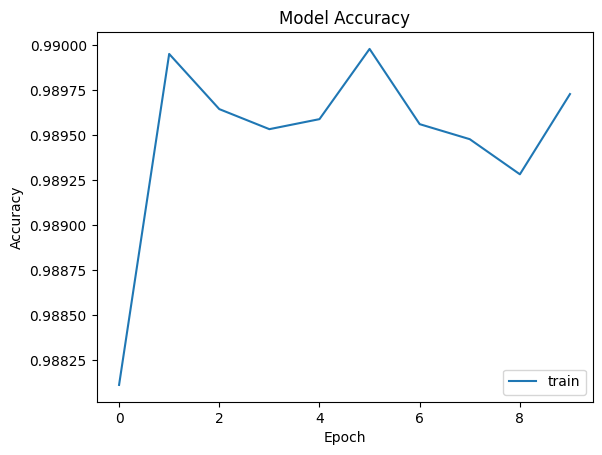

281/281 [==============================] - 1s 2ms/step


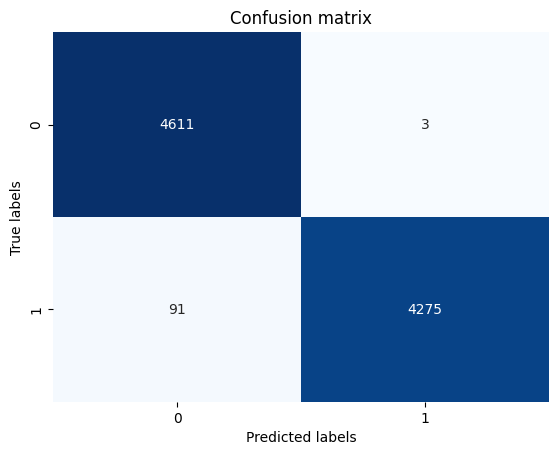

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4614
           1       1.00      0.98      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1796/1796 [==============================] - 13s 6ms/step - loss: 0.1773 - accuracy: 0.9869
Epoch 2/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0601 - accuracy: 0.9896
Epoch 3/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0563 - accuracy: 0.9897
Epoch 4/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0561 - accuracy: 0.9897
Epoch 5/10
1796/1796 [==============================] - 11s 6ms/step - loss: 0.0533 - accuracy: 0.9895
Epoch 6/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0530 - accuracy: 0.9901
Epoch 7/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0506 - accuracy: 0.9896
Epoch 8/10
1796/1796 [==============================] - 10s 6ms/step - loss: 0.0493 - accuracy: 0.9900
Epoch 9/10
1796/1796 [==============================] - 10s 5ms/step - loss: 0.0477 - accuracy: 0.9900
Epoch 10/10
449/449 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.99 (+/- 0.00)
Cross-Validation Precision: 0.99 (+/- 0.01)
Cross-Validation Loss: 0.04 (+/- 0.01)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.99 (+/- 0.00)


# **Text-Title-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings1 = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_text_distilbert.npy')
labels1 = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_text_distilbert.npy')

In [ ]:
train_embeddings1, test_embeddings1, train_labels1, test_labels1 = train_test_split(embeddings1, labels1, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

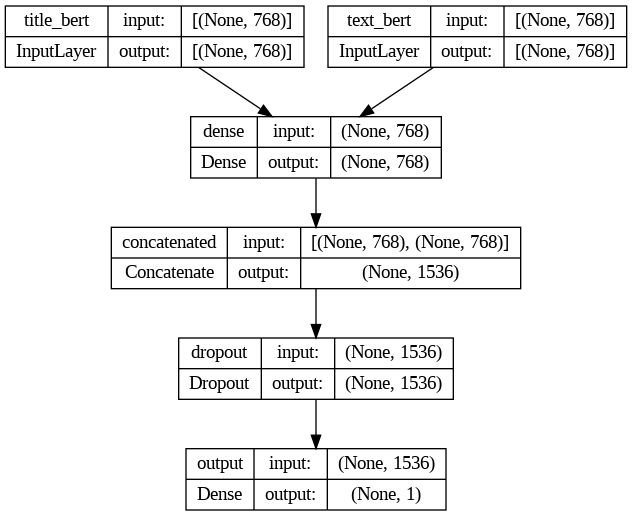

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=10,
          batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 15s 4ms/step - loss: 0.0047 - accuracy: 0.9995
Epoch 2/10
2245/2245 [==============================] - 11s 5ms/step - loss: 0.0059 - accuracy: 0.9997
Epoch 3/10
2245/2245 [==============================] - 10s 5ms/step - loss: 0.0079 - accuracy: 0.9997
Epoch 4/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0070 - accuracy: 0.9998
Epoch 5/10
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0097 - accuracy: 0.9997
Epoch 6/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0128 - accuracy: 0.9997
Epoch 7/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0151 - accuracy: 0.9997
Epoch 8/10
2245/2245 [==============================] - 10s 5ms/step - loss: 0.0075 - accuracy: 0.9997
Epoch 9/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0078 - accuracy: 0.9997
Epoch 10/10
2245/2245 [==============================] - 10s 5ms/step - loss:

In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 1s - loss: 0.0166 - accuracy: 0.9997 - 727ms/epoch - 3ms/step
281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9996659159660339
Test F1 Score: 0.9996563967472226
Test Recall: 0.9995419147961521
Precision: 0.9997709049255441


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense[0][0]',              

281/281 [==============================] - 1s 2ms/step
[[4613    1]
 [   2 4364]]


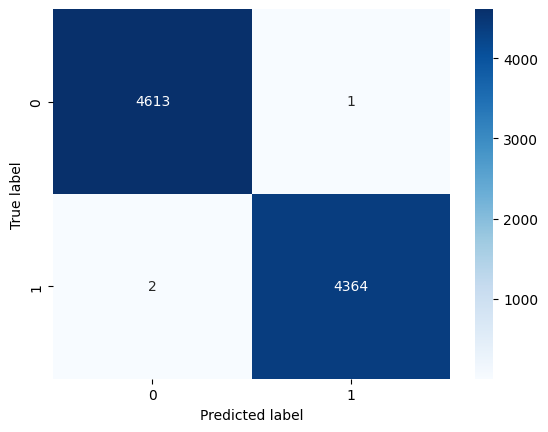

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def accuracy(y_true, y_pred):
    predictions = K.round(y_pred)
    correct_predictions = K.cast(K.equal(y_true, predictions), dtype='float32')
    accuracy_value = K.mean(correct_predictions)
    return accuracy_value

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_value

def neg_log_loss(y_true, y_pred):
    loss = K.binary_crossentropy(y_true, y_pred)
    return -loss

def create_model():
    title_input = Input(shape=(768,), name='title_bert')
    text_input = Input(shape=(768,), name='text_bert')
    shared_dense = Dense(768, activation='relu')
    title_output = shared_dense(title_input)
    text_output = shared_dense(text_input)
    concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
    dropped_out = Dropout(0.5)(concatenated)
    output = Dense(1, activation='sigmoid', name='output')(dropped_out)
    model = Model(inputs=[title_input, text_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1_score, neg_log_loss])
    return model

scoring = ['accuracy', 'precision', 'recall', 'f1_score', 'neg_log_loss']

X = [tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)]
y = train_labels

results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_indices, val_indices in kfold.split(X[0], y):
    train_indices = tf.constant(train_indices)
    val_indices = tf.constant(val_indices)

    X_train = [tf.gather(X[0], train_indices), tf.gather(X[1], train_indices)]
    X_val = [tf.gather(X[0], val_indices), tf.gather(X[1], val_indices)]
    y_train = tf.gather(y, train_indices)
    y_val = tf.gather(y, val_indices)

    model = create_model()

    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    fold_results = {}
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    for metric, score in zip(model.metrics_names, eval_results):
        if metric == 'neg_log_loss':
            fold_results[metric] = -score
        else:
            fold_results[metric] = score
    results.append(fold_results)


mean_results = {metric: np.mean([fold[metric] for fold in results]) for metric in scoring}
std_results = {metric: np.std([fold[metric] for fold in results]) for metric in scoring}

for metric in scoring:
    print('=========================================')
    print(metric, "Mean:", mean_results[metric])
    print(metric, "Std:", std_results[metric])
    print('=========================================')


accuracy Mean: 0.9998055696487427
accuracy Std: 0.00011110305786132812
precision Mean: 0.999820077419281
precision Std: 0.0001491064799635587
recall Mean: 0.9997723698616028
recall Std: 0.00021169289555269323
f1_score Mean: 0.9997891664505005
f1_score Std: 0.00012539228118357005
neg_log_loss Mean: 0.008653193041800922
neg_log_loss Std: 0.0069884025753205025


# **Max Worth-Title-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings1 = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_textmax_distilbert.npy')
labels1 = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_textmax_distilbert.npy')

In [ ]:
train_embeddings1, test_embeddings1, train_labels1, test_labels1 = train_test_split(embeddings1, labels1, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([35918, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=10,
          batch_size=16)

Epoch 1/10
2245/2245 [==============================] - 16s 7ms/step - loss: 0.0203 - accuracy: 0.9971
Epoch 2/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0176 - accuracy: 0.9983
Epoch 3/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0098 - accuracy: 0.9989
Epoch 4/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0130 - accuracy: 0.9988
Epoch 5/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0082 - accuracy: 0.9989
Epoch 6/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0086 - accuracy: 0.9989
Epoch 7/10
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0132 - accuracy: 0.9990
Epoch 8/10
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0070 - accuracy: 0.9992
Epoch 9/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0050 - accuracy: 0.9993
Epoch 10/10
2245/2245 [==============================] - 9s 4ms/step - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int')

recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 1s - loss: 0.0140 - accuracy: 0.9990 - 933ms/epoch - 3ms/step
281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9989977478981018
Test F1 Score: 0.9996563967472226
Test Recall: 0.9995419147961521
Precision: 0.9983985358041638


In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_8[0][0]',          

281/281 [==============================] - 1s 3ms/step
[[4607    7]
 [   2 4364]]


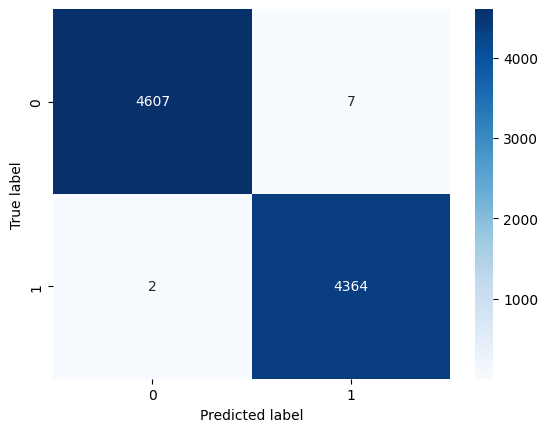

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def accuracy(y_true, y_pred):
    predictions = K.round(y_pred)
    correct_predictions = K.cast(K.equal(y_true, predictions), dtype='float32')
    accuracy_value = K.mean(correct_predictions)
    return accuracy_value

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_value

def neg_log_loss(y_true, y_pred):
    loss = K.binary_crossentropy(y_true, y_pred)
    return -loss

def create_model():
    title_input = Input(shape=(768,), name='title_bert')
    text_input = Input(shape=(768,), name='text_bert')
    shared_dense = Dense(768, activation='relu')
    title_output = shared_dense(title_input)
    text_output = shared_dense(text_input)
    concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
    dropped_out = Dropout(0.5)(concatenated)
    output = Dense(1, activation='sigmoid', name='output')(dropped_out)
    model = Model(inputs=[title_input, text_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1_score, neg_log_loss])
    return model

scoring = ['accuracy', 'precision', 'recall', 'f1_score', 'neg_log_loss']

X = [tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)]
y = train_labels

results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_indices, val_indices in kfold.split(X[0], y):
    train_indices = tf.constant(train_indices)
    val_indices = tf.constant(val_indices)

    X_train = [tf.gather(X[0], train_indices), tf.gather(X[1], train_indices)]
    X_val = [tf.gather(X[0], val_indices), tf.gather(X[1], val_indices)]
    y_train = tf.gather(y, train_indices)
    y_val = tf.gather(y, val_indices)

    model = create_model()

    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    fold_results = {}
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    for metric, score in zip(model.metrics_names, eval_results):
        if metric == 'neg_log_loss':
            fold_results[metric] = -score
        else:
            fold_results[metric] = score
    results.append(fold_results)

mean_results = {metric: np.mean([fold[metric] for fold in results]) for metric in scoring}
std_results = {metric: np.std([fold[metric] for fold in results]) for metric in scoring}

for metric in scoring:
    print('=========================================')
    print(metric, "Mean:", mean_results[metric])
    print(metric, "Std:", std_results[metric])
    print('=========================================')

accuracy Mean: 0.9995277762413025
accuracy Std: 0.0003578878979285869
precision Mean: 0.9995232939720153
precision Std: 0.00036617728882170725
recall Mean: 0.9994684219360351
recall Std: 0.0006548976151475257
f1_score Mean: 0.9994777798652649
f1_score Std: 0.0004035569748267219
neg_log_loss Mean: 0.00263840175466612
neg_log_loss Std: 0.0011462178837491133
